In [1]:
# Module imports
import seaborn as sns
from pandas import DataFrame, concat, Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
path = 'EEGEyeState_Training.arff.csv'
path_test = 'EEGEyeState_Testing.arff.csv'
lag = 0
index_counter = 0
#
df = pd.read_csv(path)
df_values = df.values
df_values_count = len(df_values)
df_headers = df.columns
df_header_count = len(df_headers)
#
print('DF size before outlier removal: ' + str(df_values_count))

DF size before outlier removal: 10000


# Data Representation

### Box Plot EEG Eye State data set representation

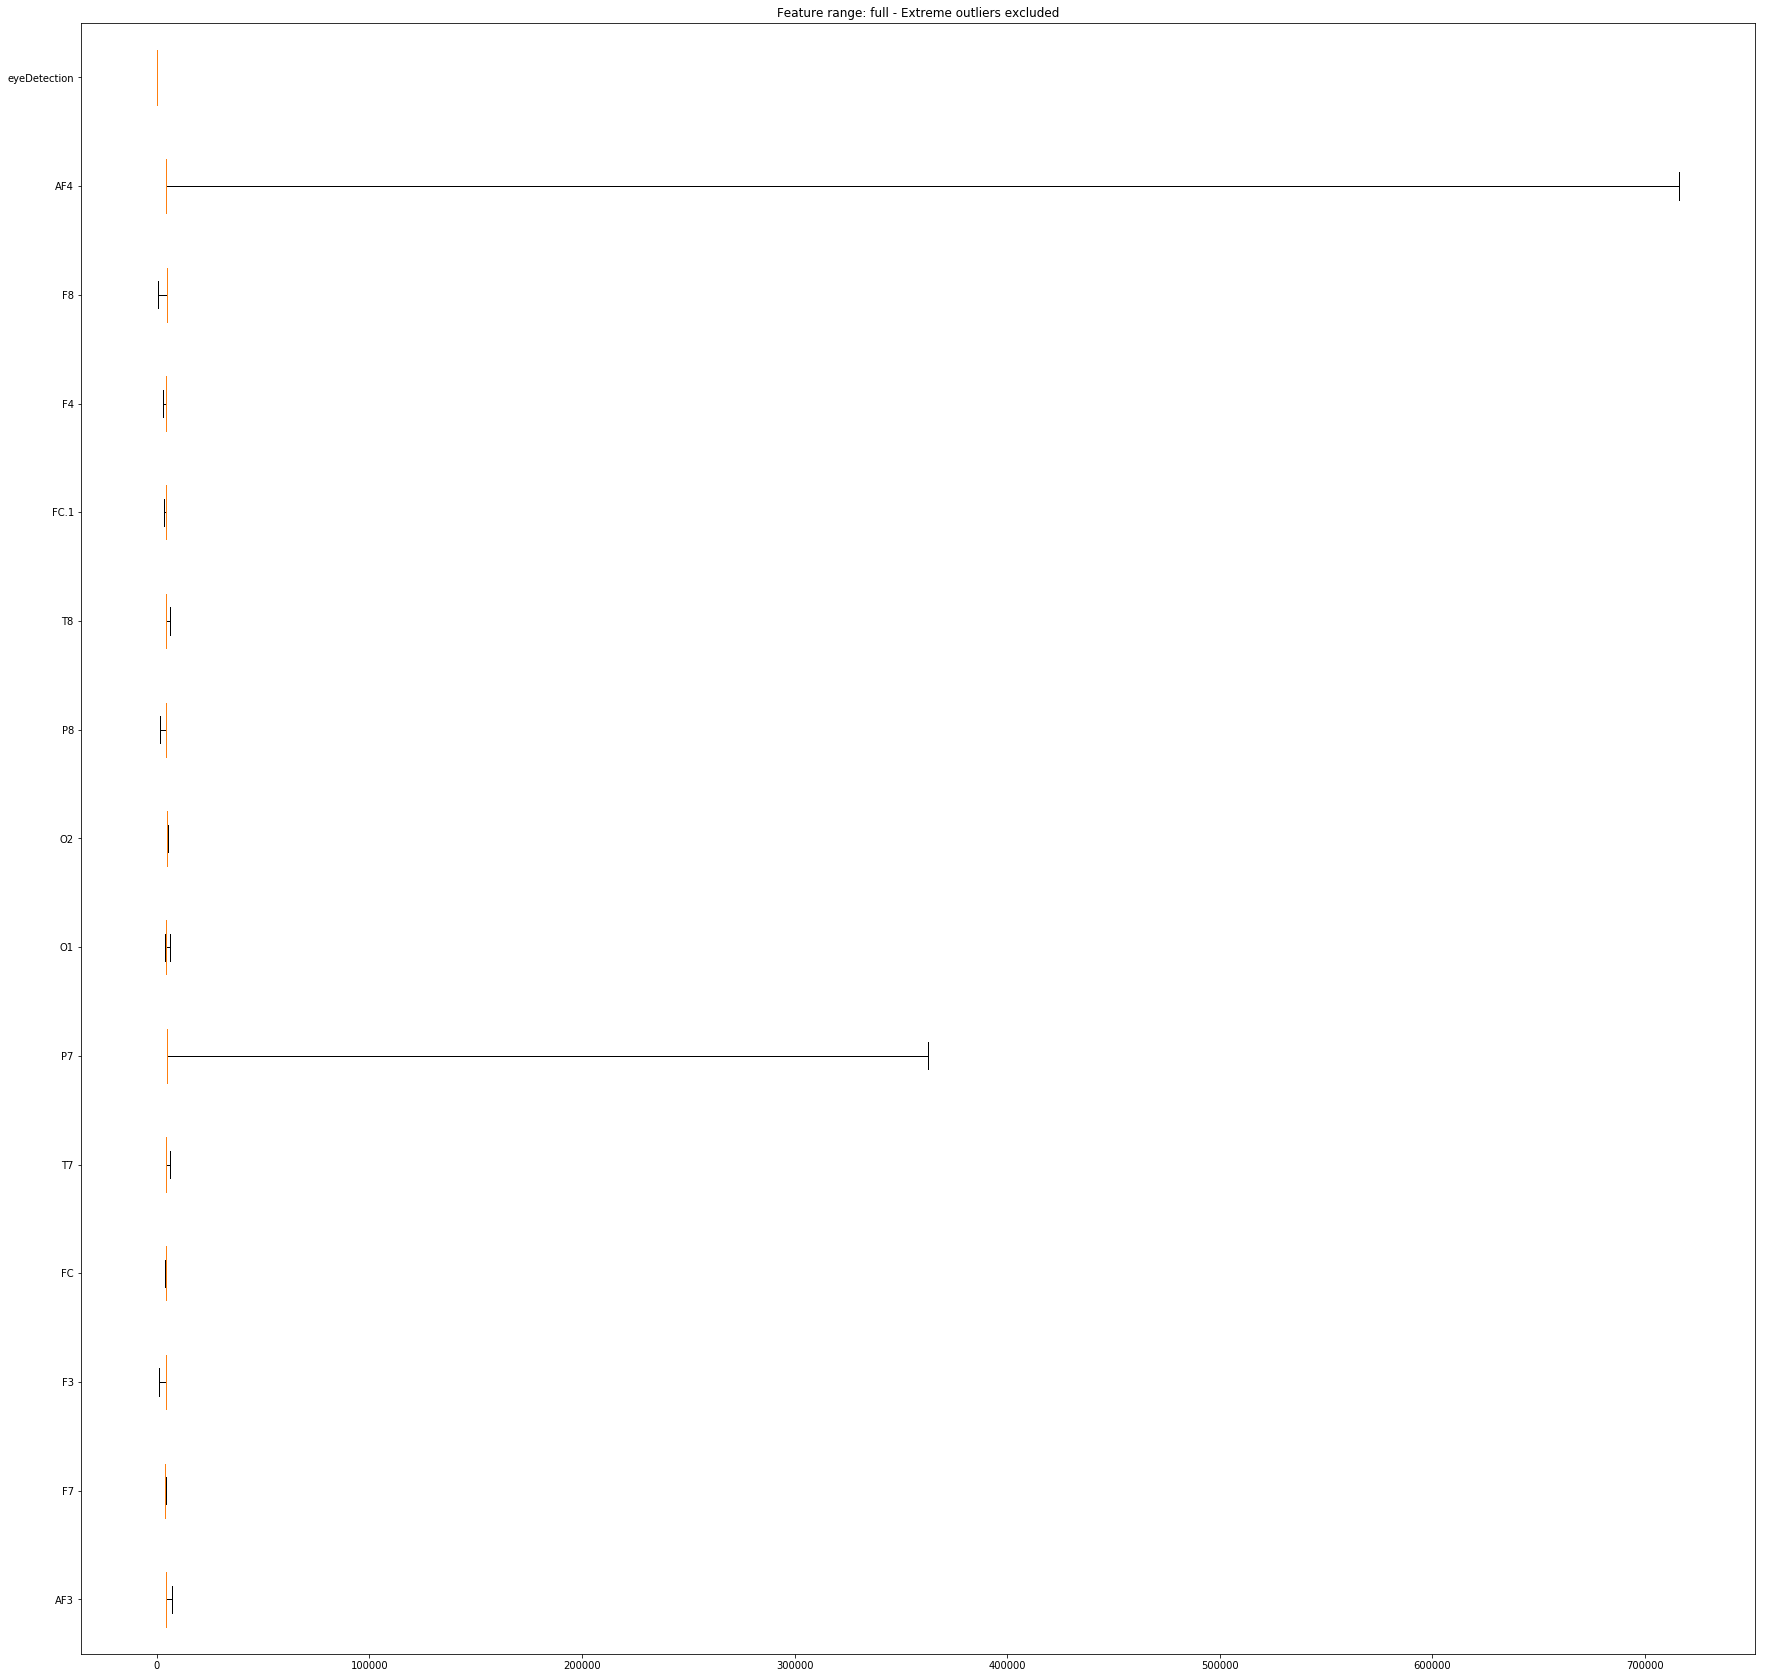

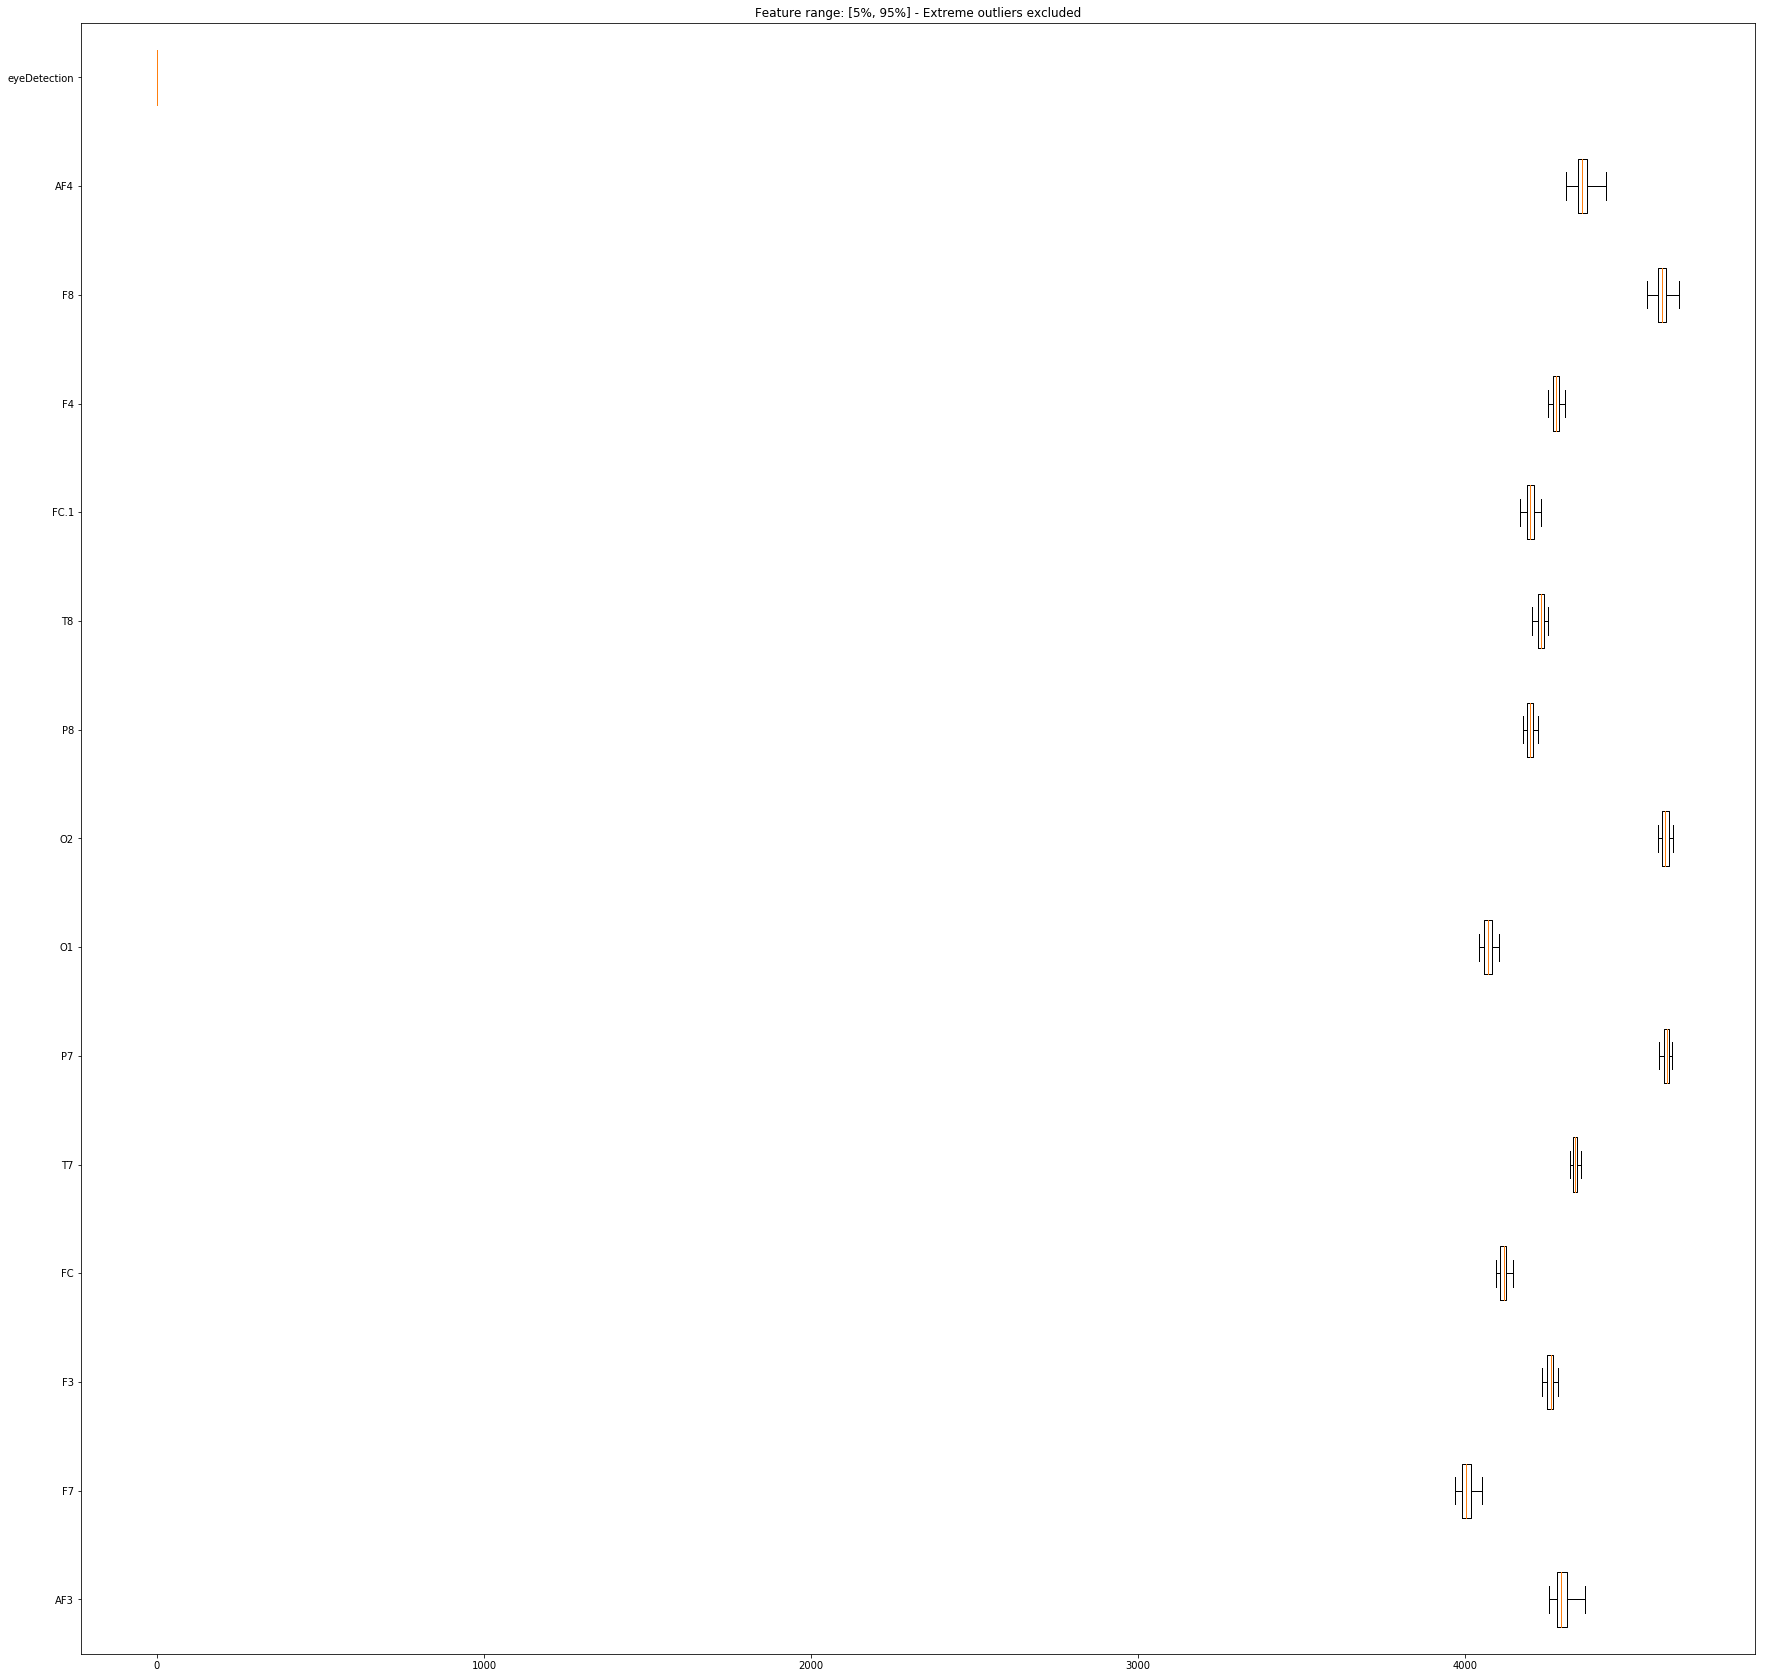

In [3]:
# Plot Box Plots
def plotBoxPlots(data, arrLabels, titleSuffix):
    fig = plt.figure()
    fig.set_figwidth(30)
    fig.set_figheight(30)

    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_title('Feature range: full - ' + titleSuffix)
    suppress = ax1.boxplot(data
                           , sym='b.'
                           , vert=False
                           , whis='range'
                           , labels=arrLabels
                           , meanline=True
                           , showbox=True
                           , showfliers=True
                           )
    plt.show()
    #
    fig = plt.figure()
    fig.set_figwidth(30)
    fig.set_figheight(30)
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title('Feature range: [5%, 95%] - ' + titleSuffix)
    suppress = ax2.boxplot(data
                           , sym='b.'
                           , vert=False
                           , whis=[5, 95]
                           , labels=arrLabels
                           , meanline=True
                           , showbox=True
                           , showfliers=False
                           )
    plt.show()
#
# Plotting Box Plots
plotBoxPlots(df_values[:,0:df_header_count], df_headers, 'Extreme outliers excluded')

### Scatter Plot representation of the EEG Eye State data set

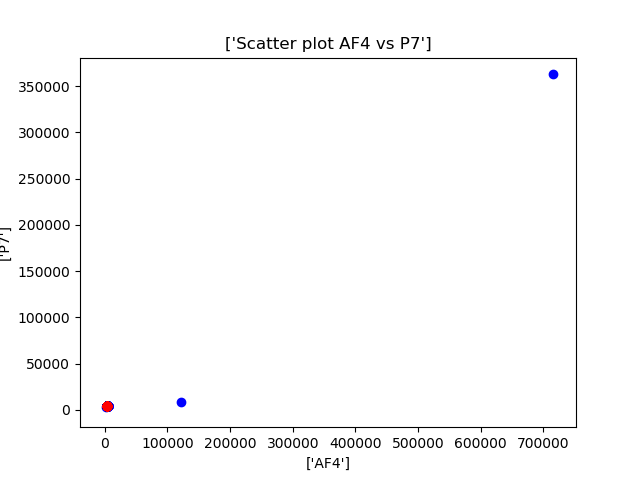

In [4]:
from IPython.display import Image
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['AF4'] vs ['P7'] Raw.png")

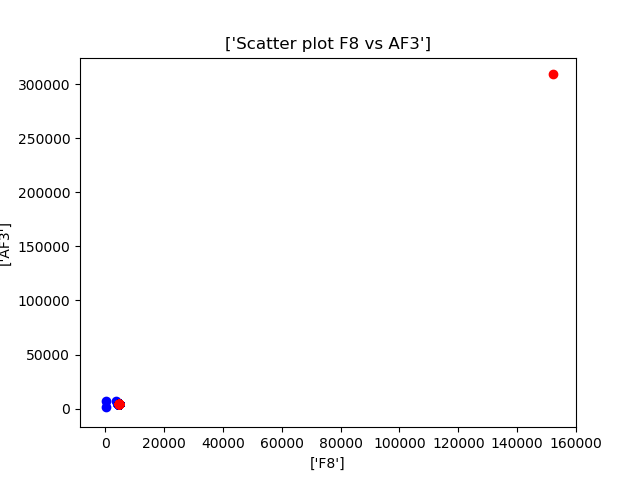

In [5]:
from IPython.display import Image
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['F8'] vs ['AF3'] Raw.png")

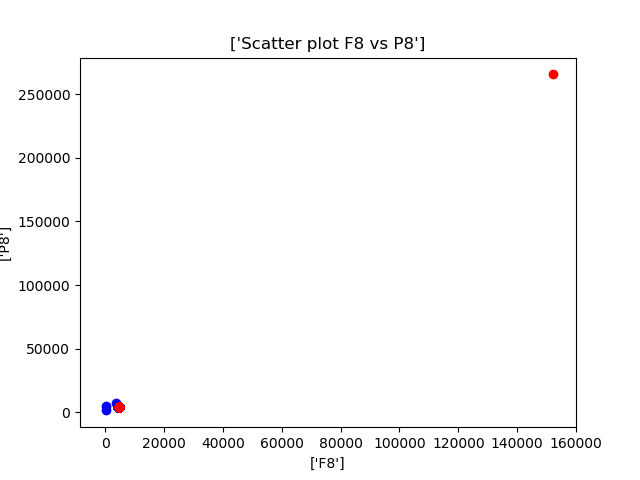

In [6]:
from IPython.display import Image
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['F8'] vs ['P8'] Raw.png")

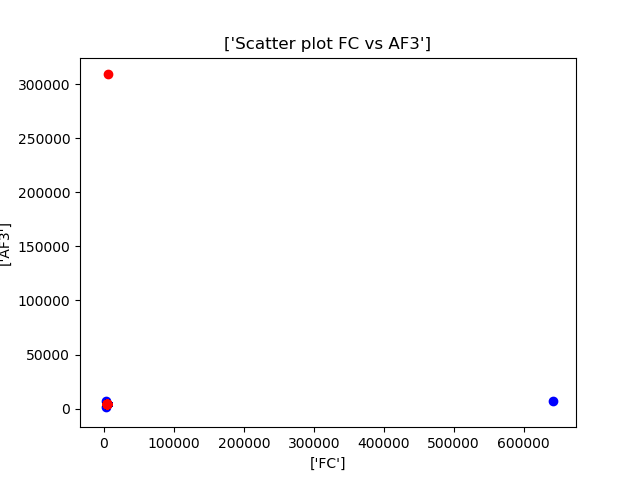

In [7]:
from IPython.display import Image
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['FC'] vs ['AF3'] Raw.png")

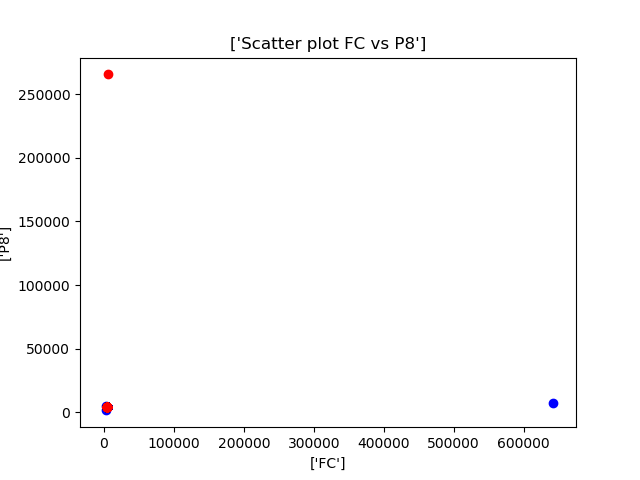

In [8]:
from IPython.display import Image
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['FC'] vs ['P8'] Raw.png")

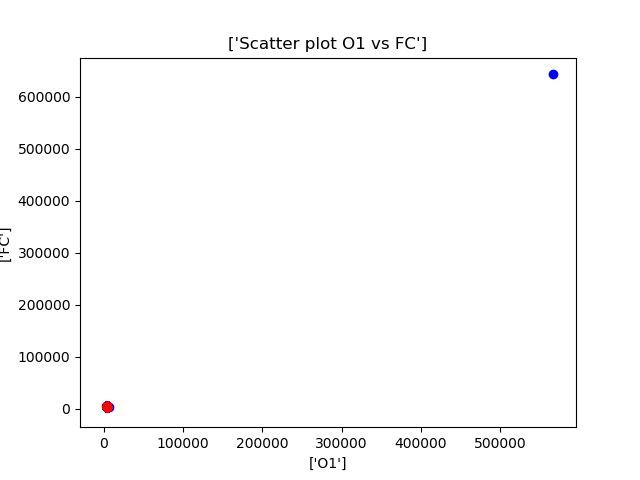

In [9]:
from IPython.display import Image
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['O1'] vs ['FC'] Raw.png")

# Data Representation

### Box Plots EEG Eye State data set excluding outliers

In [10]:
# Removing outliers
def get_outlier_indexes(df, df_col_count, outlier_value=5000):
    """ Takes a dataframe and returns the position of any outliers """
    outLierIndexes = set()
    upperLimit = outlier_value
    for x in range(df_col_count):
        df = np.array(df)
        outLiers = np.where(df[:, x] > upperLimit)[0]
        if len(outLiers) > 0:
            [(outLierIndexes.add(outLiers[i])) for i in range(len(outLiers))]
    #
    outLierIndexes = list(outLierIndexes)
    outLierIndexes.sort()
    return outLierIndexes
#
outlier_indexes = get_outlier_indexes(df_values, df_header_count)
print('Extreme outliers\nTotal:   ', len(outlier_indexes), \
    '\nIndexes: ', outlier_indexes)
# [(print(DataFrame(df).iloc[[outlier]])) for outlier in outlier_indexes]
df_values_pruned = np.delete(df_values, outlier_indexes, 0)
df_values_pruned_count = len(df_values_pruned)
df_pruned = pd.DataFrame(data=df_values_pruned, columns=df_headers)
#
print('DF size after outlier removal: ' + str(df_values_pruned_count))

Extreme outliers
Total:    1 
Indexes:  [898]
DF size after outlier removal: 9999


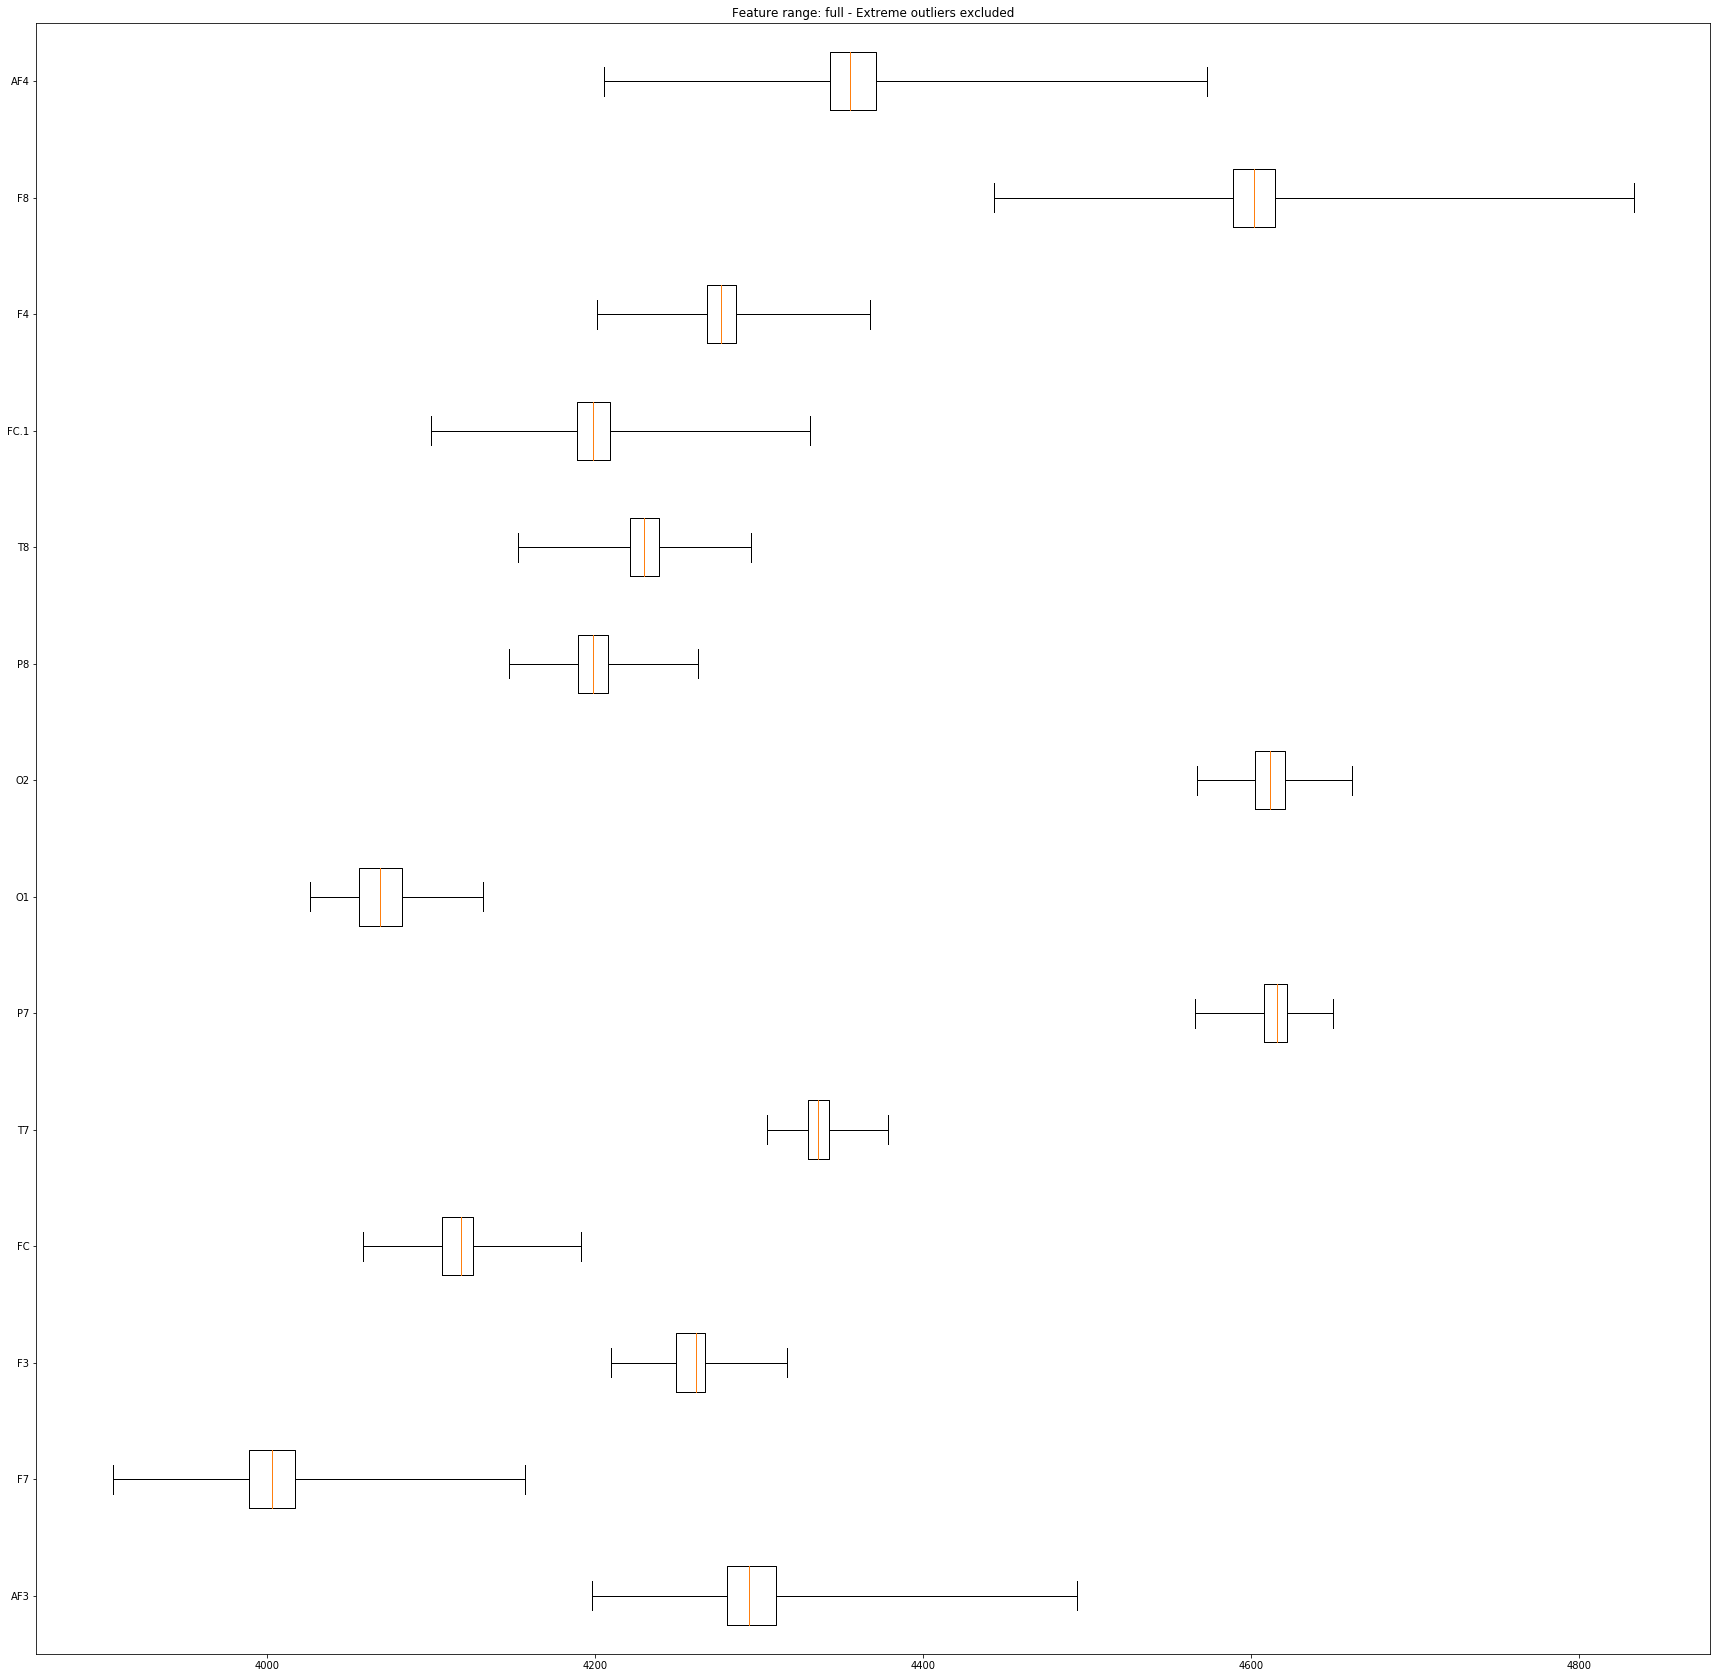

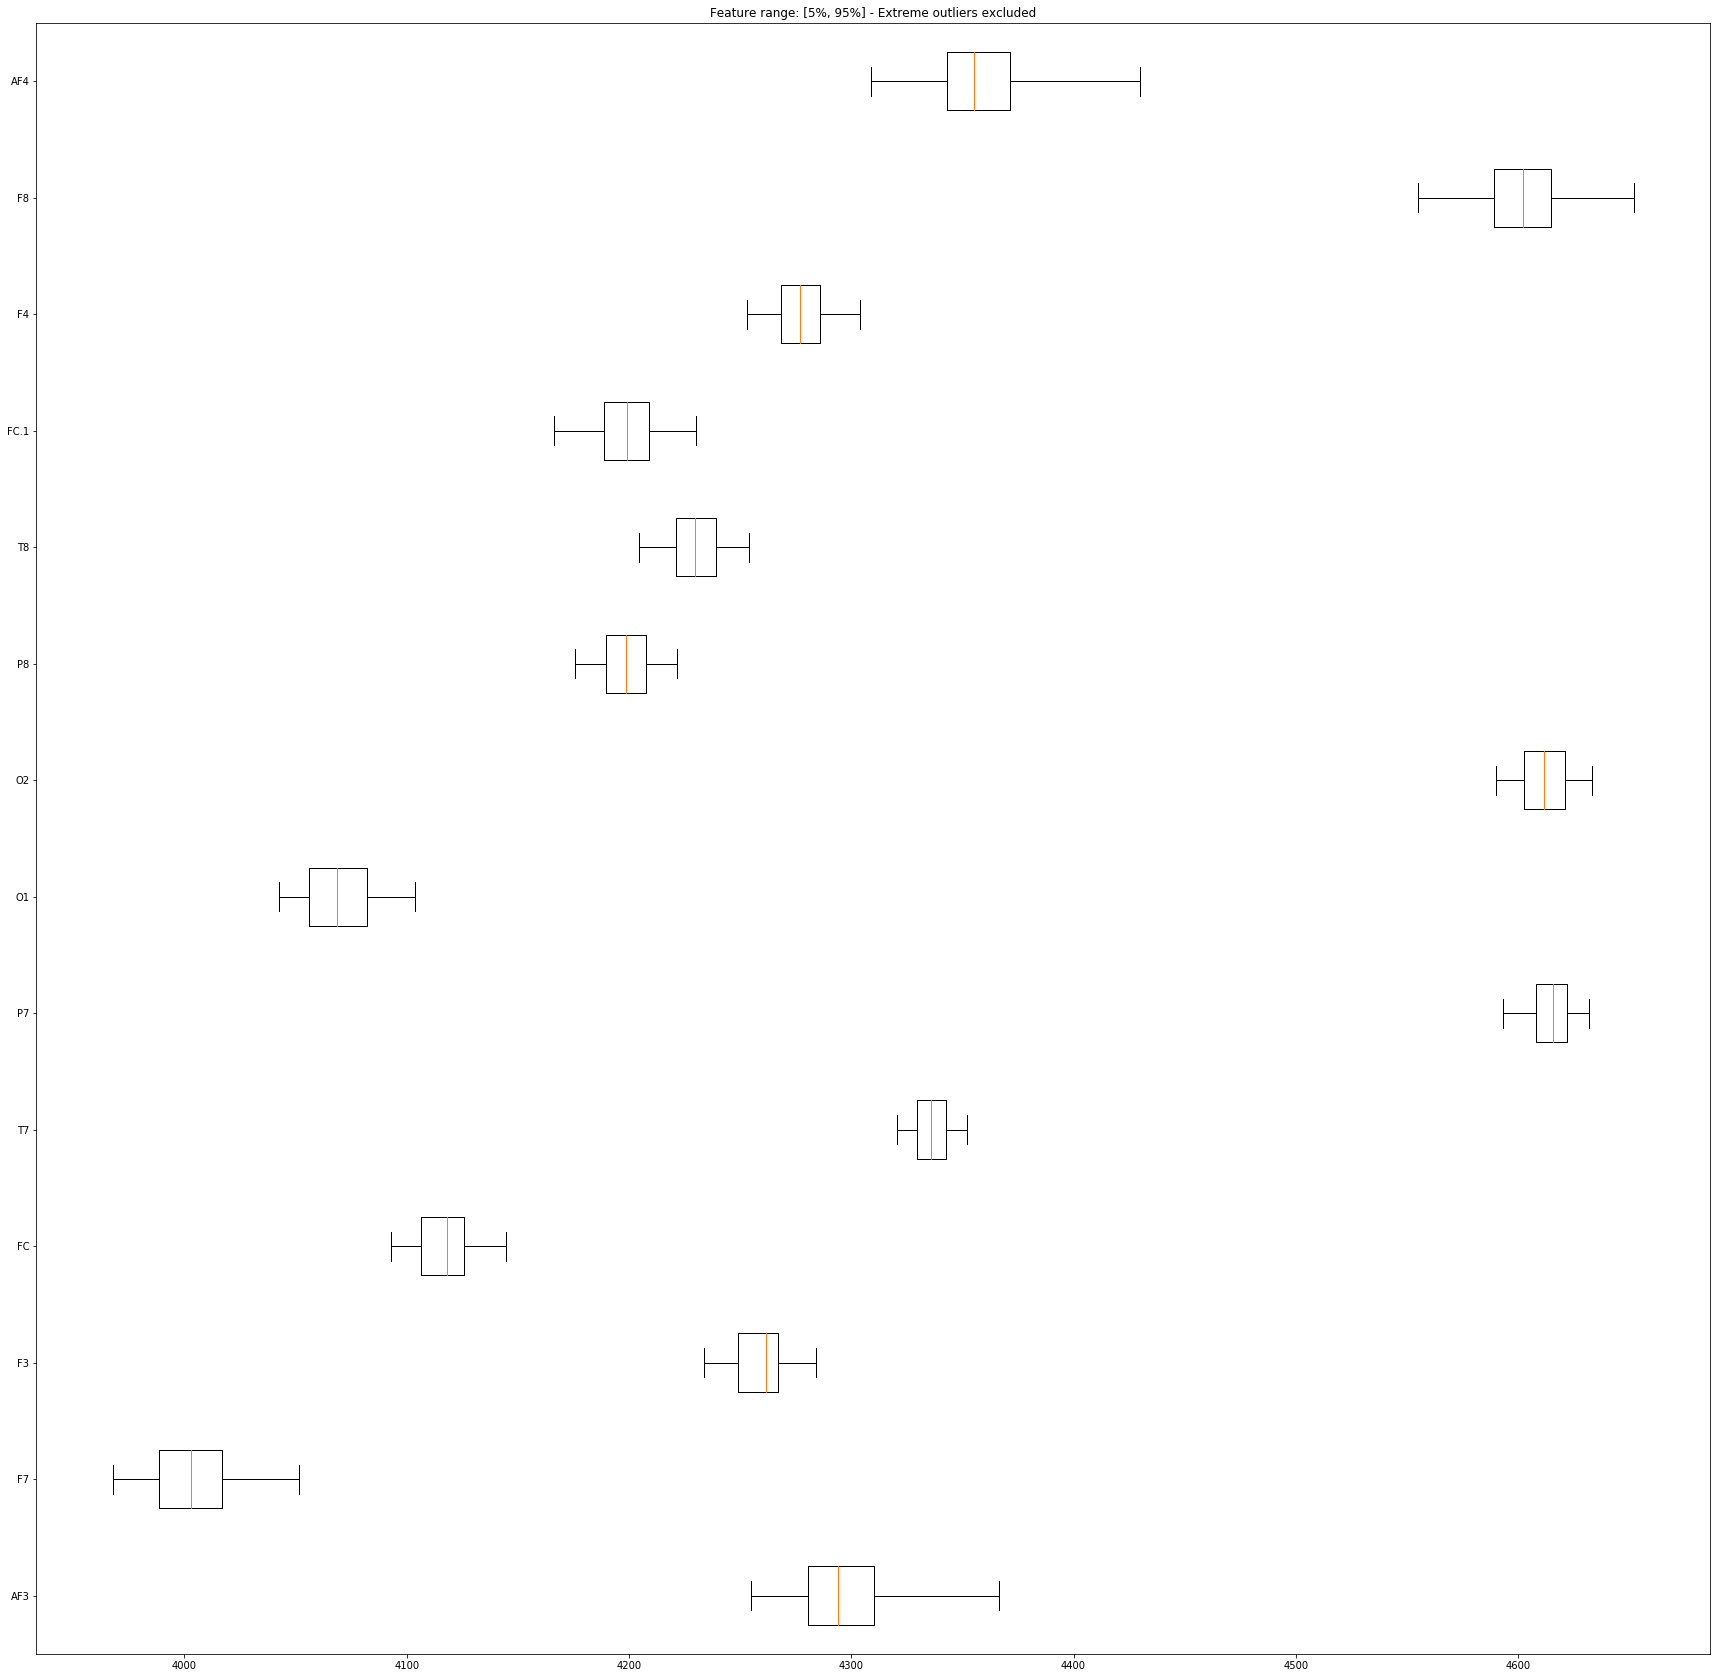

In [11]:
#
# Plotting Box Plots
eegDataNoOutLiers_y = df_pruned['eyeDetection']
eegDataNoOutLiers_X = df_pruned.drop('eyeDetection', 1)
plotBoxPlots(eegDataNoOutLiers_X.values[:,0:len(eegDataNoOutLiers_X.columns)], eegDataNoOutLiers_X.columns, 'Extreme outliers excluded')

### Scatter Plot representation of the EEG Eye State data set (excluding outliers)

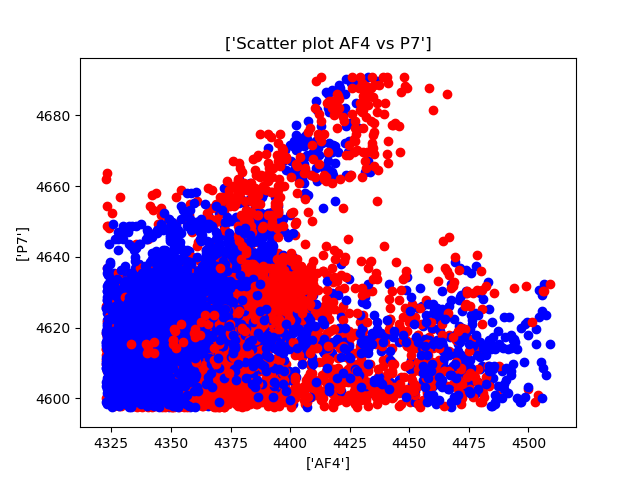

In [12]:
from IPython.display import Image
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['AF4'] vs ['P7'].png")

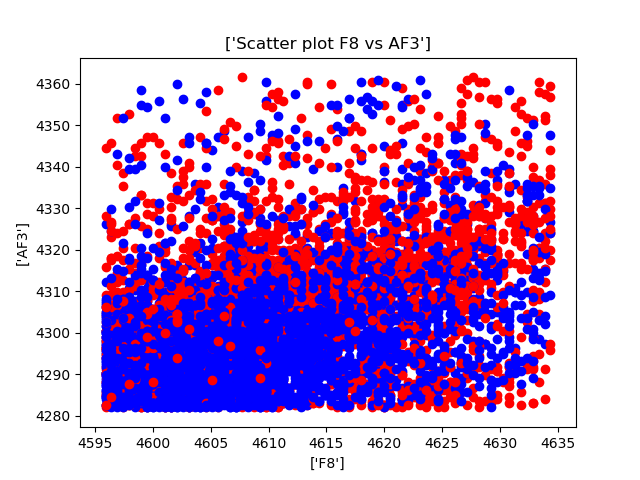

In [13]:
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['F8'] vs ['AF3'].png")

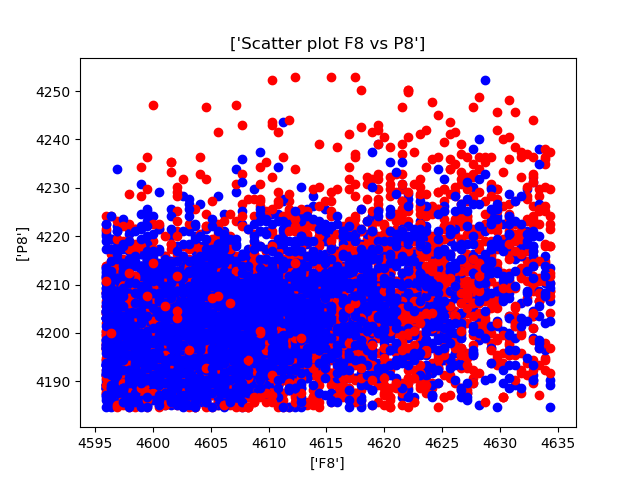

In [14]:
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['F8'] vs ['P8'].png")

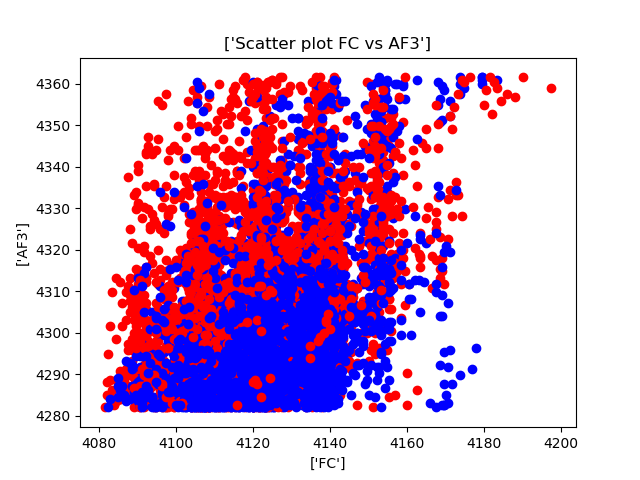

In [15]:
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['FC'] vs ['AF3'].png")

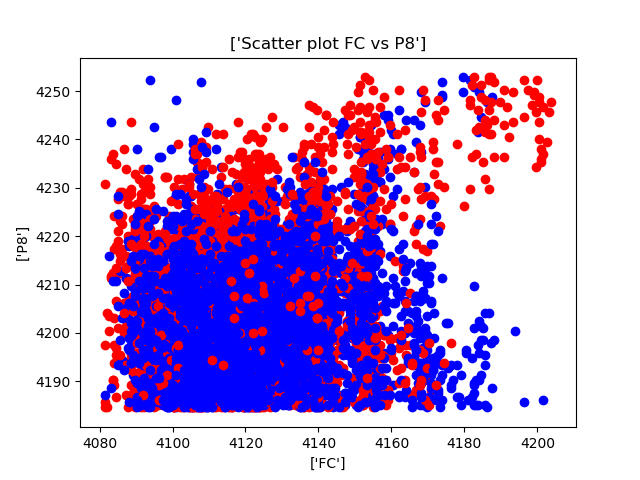

In [16]:
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['FC'] vs ['P8'].png")

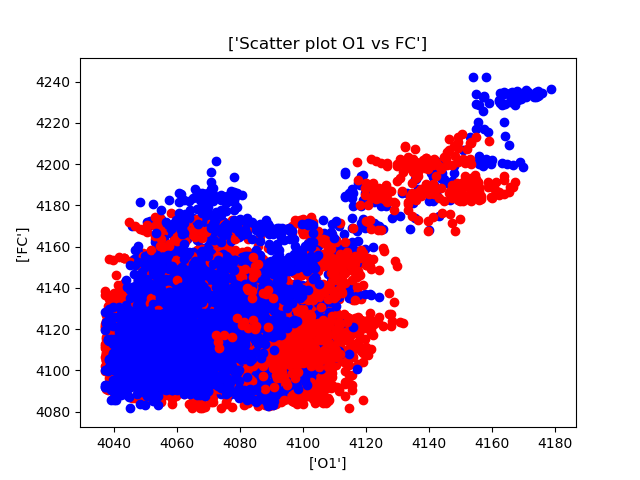

In [17]:
# Red = EyeClosed, Blue = EyeOpen
Image(filename="Images/Scatter plot ['O1'] vs ['FC'].png")

# Time Series Analysis

### EEG Eye State data set time shifting (lag set to 0)

In [18]:
# Applying lag to timeseries data set, by shifting degree of n
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
#
# N-Step Univariate Forecasting Shift
df_pruned_shifted = series_to_supervised(data=df_pruned, n_in=lag, n_out=1, dropnan=True)
#
# Removing any lag variables of var15(t-lag) (label)
if lag > 0:
    for i in range(1,lag+1):
        df_pruned_shifted = df_pruned_shifted.drop('var15(t-' + str(i) + ')', 1)
df_pruned_shifted_headers = df_pruned_shifted.columns
df_pruned_shifted_header_count = len(df_pruned_shifted_headers)
print(df_pruned_shifted_headers)

Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)',
       'var13(t)', 'var14(t)', 'var15(t)'],
      dtype='object')


### Line plots of feature readings over time (117 seconds)

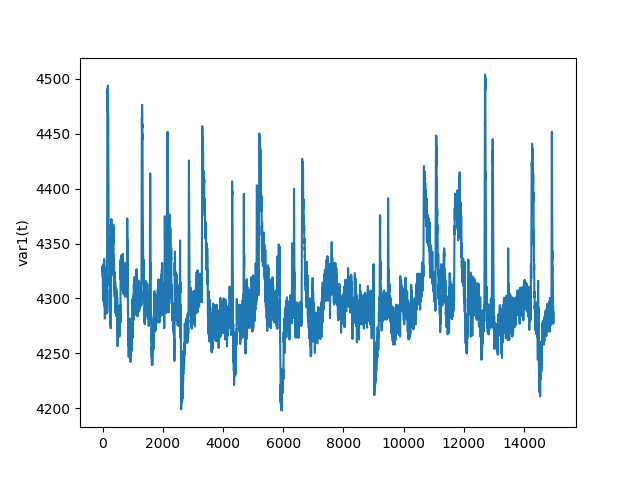

In [19]:
# AF3 line graph
Image(filename="Images/AF3.png")

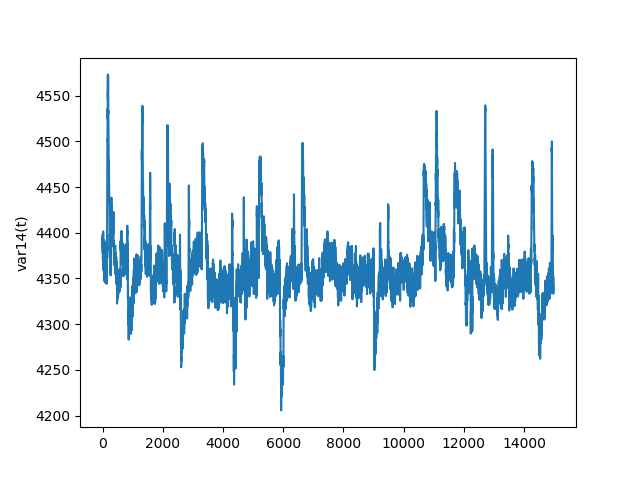

In [20]:
# AF4 line graph
Image(filename="Images/AF4.png")

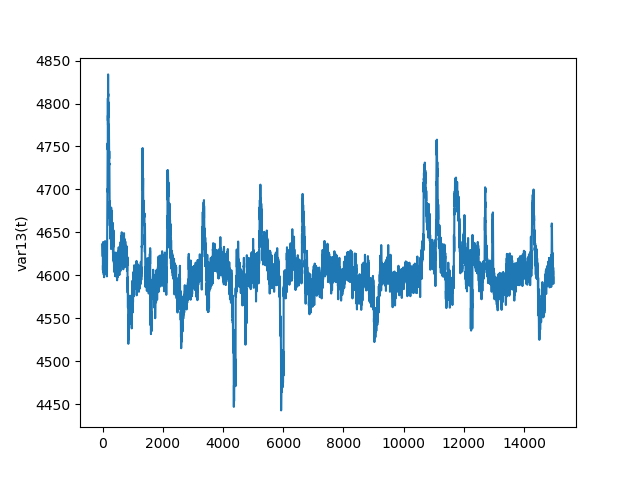

In [21]:
# F8 line graph
Image(filename="Images/F8.png")

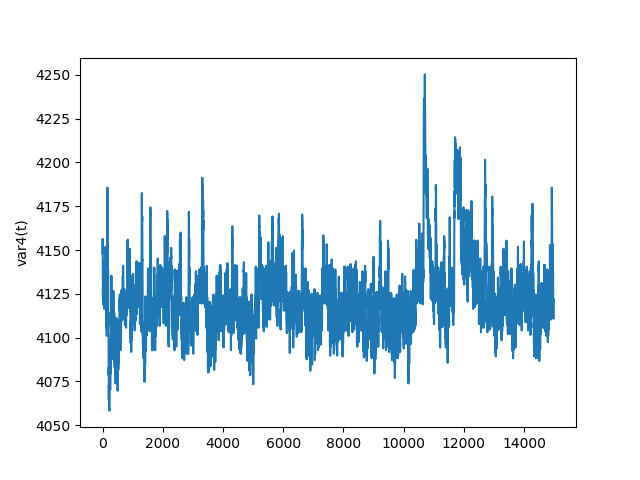

In [22]:
# FC line graph
Image(filename="Images/FC.png")

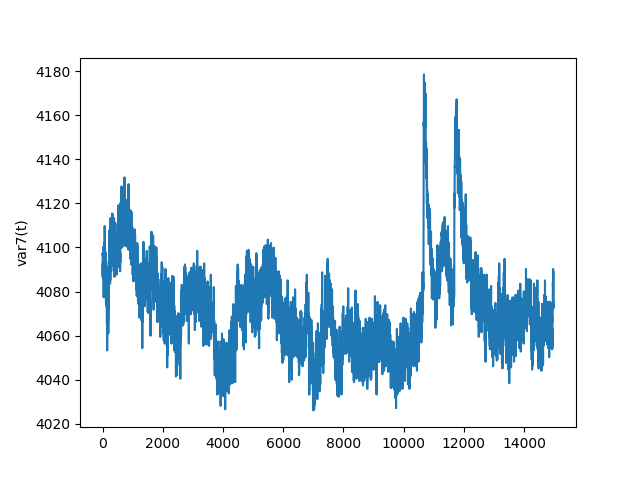

In [23]:
# O1 line graph
Image(filename="Images/O1.png")

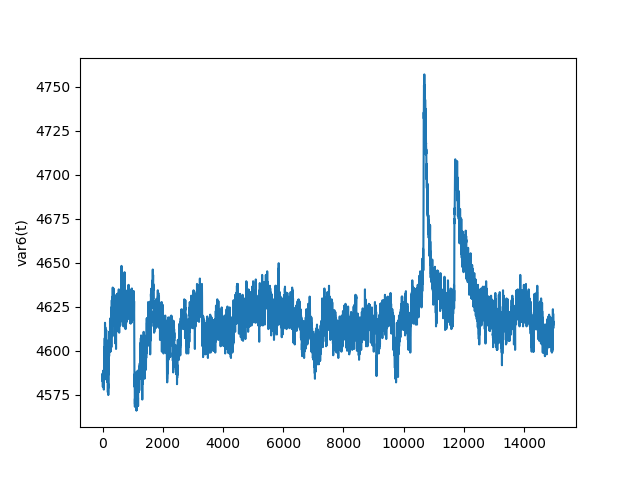

In [24]:
# P7 line graph
Image(filename="Images/P7.png")

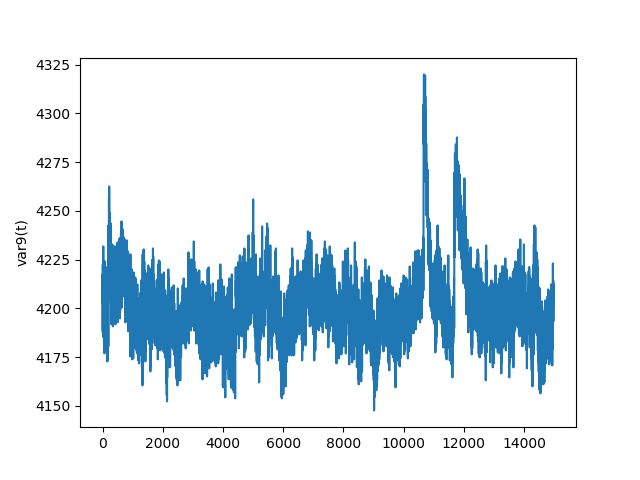

In [25]:
# P8 line graph
Image(filename="Images/P8.png")

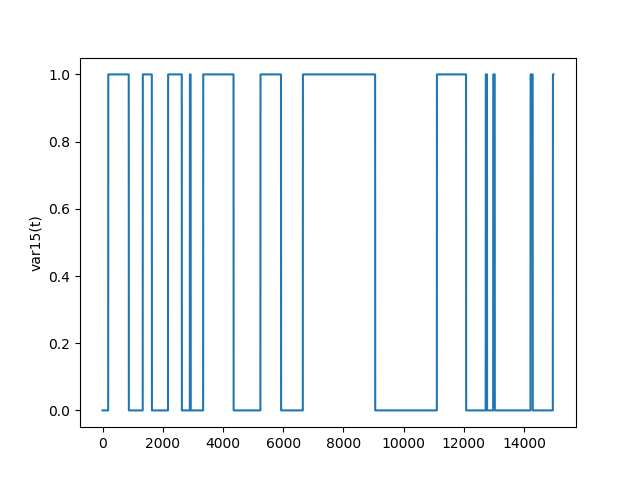

In [26]:
# eyeDetection line graph
Image(filename="Images/eyeDetection.png")

# Feature Selection - Filter Methods

### Pearson Correlation Matrix

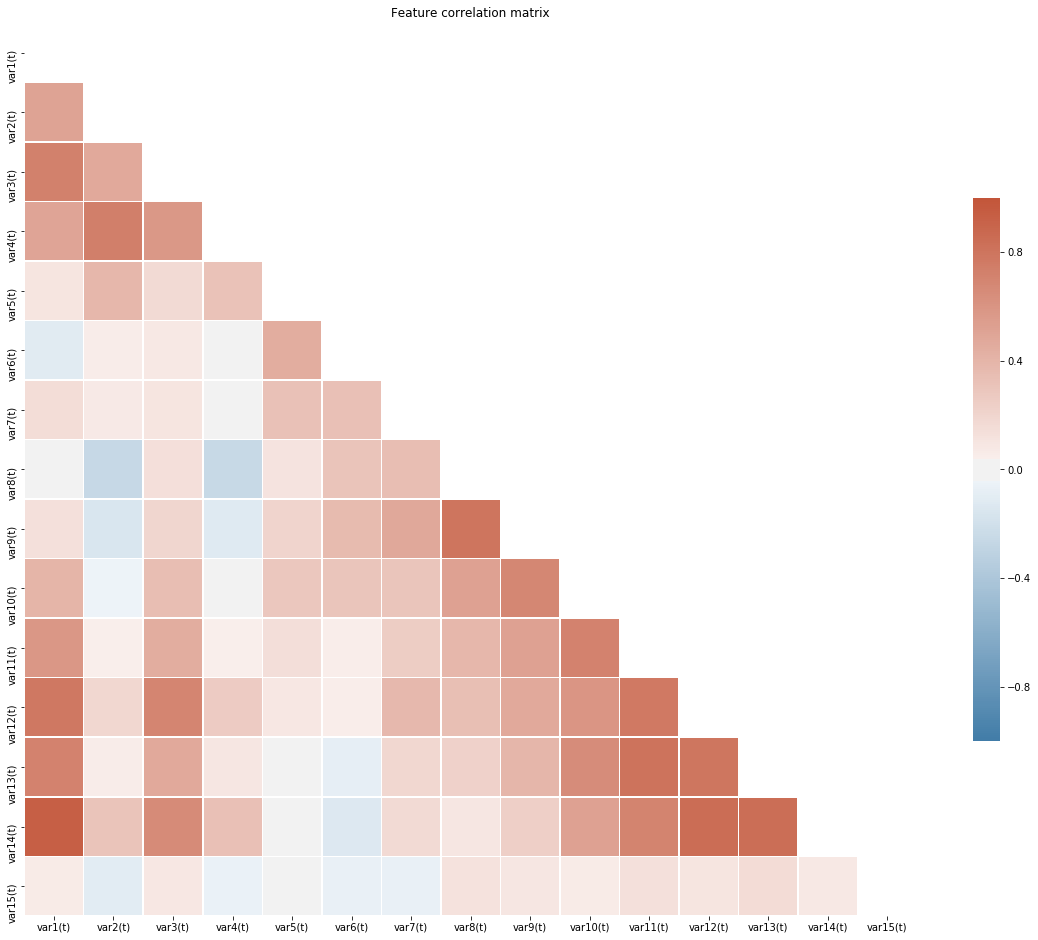

In [27]:
# Plot Pearson's Correlation Matrix for shifted_df
eegDF = pd.DataFrame(data=df_pruned_shifted, columns=df_pruned_shifted_headers)
#
# Compute the correlation matrix
corr = eegDF.corr()
#
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#
# Set up the matplotlib figure
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
#
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Feature correlation matrix")
#
# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 20, as_cmap=True)
#
# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()
#
# Store the upper triangle of the correlation matrix into an Excel sheet
corrUpperTri = corr.where(mask)
writer = pd.ExcelWriter('EEG_Shifted_Correlation_Matrix.xlsx')
corrUpperTri.to_excel(writer, 'CorrelationMatrix')
writer.save()

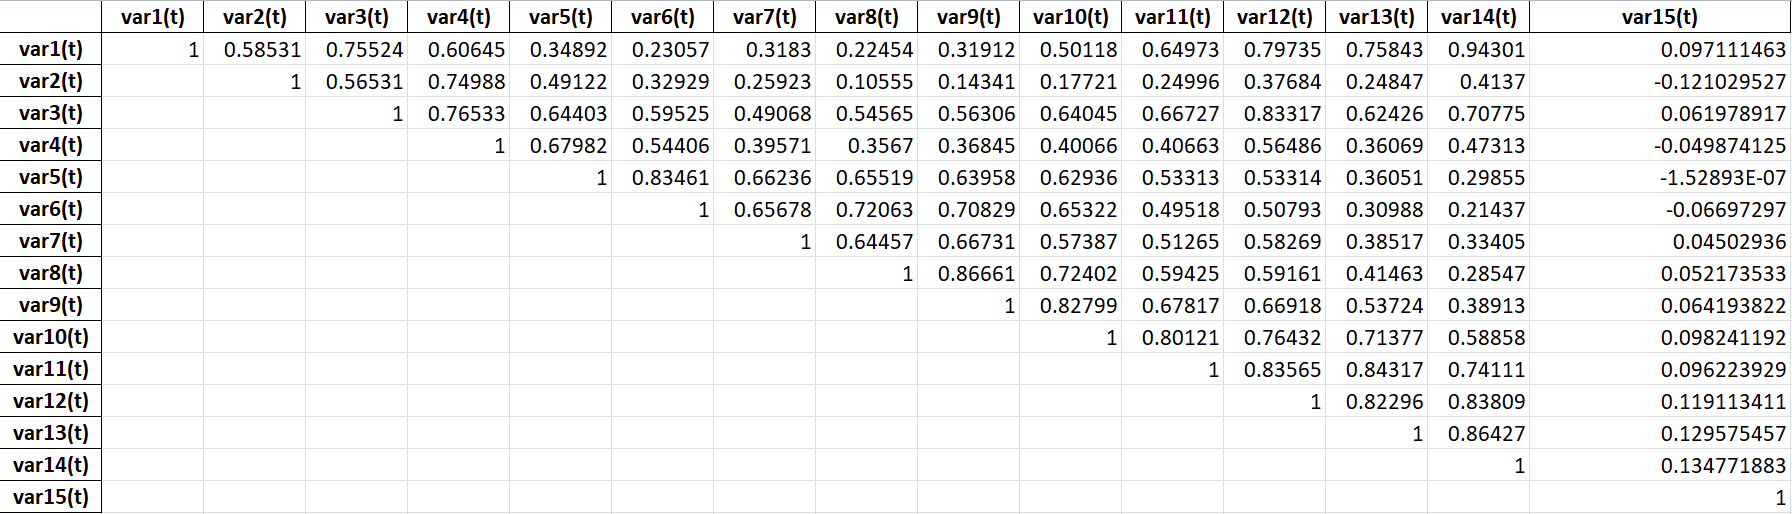

In [28]:
# Pearson's Correlation Matrix
Image(filename="Images/Correlation Matrix Excluding Outliers.png")

### Filter Methods (Mutual Information Scoring)

In [29]:
from sklearn.metrics import mutual_info_score
import operator
mi_scores = {}
for column in df_pruned_shifted_headers:
    if column != 'var15(t)':
        mi_scores[column] = mutual_info_score(df_pruned_shifted[column], df_pruned_shifted['var15(t)'])
print('Mutual Information: ')
print(sorted(mi_scores.items(), key=operator.itemgetter(1), reverse=True))

Mutual Information: 
[('var1(t)', 0.068001631969438509), ('var14(t)', 0.061312983255733783), ('var6(t)', 0.056815681032305346), ('var13(t)', 0.056309625332207881), ('var7(t)', 0.04282873920644046), ('var11(t)', 0.040537269025248061), ('var2(t)', 0.03461132683140055), ('var12(t)', 0.0283772790896249), ('var9(t)', 0.02320555796089771), ('var3(t)', 0.020713608072078921), ('var4(t)', 0.02026262824227585), ('var10(t)', 0.020162418824560796), ('var8(t)', 0.019820144087840025), ('var5(t)', 0.0086360493779071828)]


### Auto Correlation Plot for time series analysis

[ 4009.23  4004.62  4006.67 ...,  4009.23  4003.59  3997.95]


C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


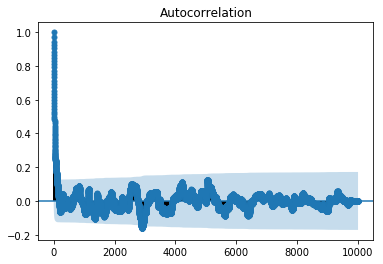

In [30]:
#
# Autocorrelation Plot
series = Series.from_csv(path, header=0)
print(series.values)
from statsmodels.graphics.tsaplots import plot_acf
if lag == 0:
    lag = None
plot_acf(series, lags=lag)
plt.show()

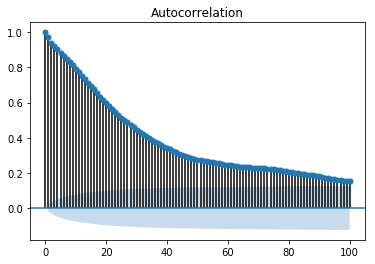

In [31]:
# Limited to lag 100
plot_acf(series, lags=100)
plt.show()

# Data normalization

In [32]:
# Splitting into feature and label sets
df_pruned_shifted_Y = df_pruned_shifted['var15(t)']
df_pruned_shifted_X = df_pruned_shifted.drop('var15(t)', 1)
df_pruned_shifted_X_headers = df_pruned_shifted_X.columns
df_pruned_shifted_X_values = df_pruned_shifted_X.values
df_pruned_shifted_X_pd = df_pruned_shifted_X
#
# L2 Normalization
# from sklearn.preprocessing import normalize
# df_pruned_shifted_X = normalize(df_pruned_shifted_X, norm='l2')
# df_pruned_shifted_X = normalize(df_pruned_shifted_X, norm='l1')
# df_pruned_shifted_Y = np.array(df_pruned_shifted_Y)
#
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_pruned_shifted_X = scaler.fit_transform(df_pruned_shifted_X)
df_pruned_shifted_Y = np.array(df_pruned_shifted_Y)
print(df_pruned_shifted_X)
print(df_pruned_shifted_Y)

[[ 0.4436634   0.41224928  0.74164956 ...,  0.47689908  0.49343604
   0.51187141]
 [ 0.42808381  0.39390322  0.78475462 ...,  0.47077883  0.48555416
   0.48535451]
 [ 0.43845894  0.40206145  0.79902967 ...,  0.48613945  0.47506206
   0.49930648]
 ..., 
 [ 0.376073    0.41224928  0.64592275 ...,  0.44923797  0.4173043
   0.43653621]
 [ 0.36742143  0.3898042   0.68426945 ...,  0.47689908  0.41205824
   0.41423482]
 [ 0.33447111  0.36735912  0.6507744  ...,  0.46153846  0.40287125
   0.41700889]]
[ 0.  0.  0. ...,  0.  0.  0.]


# Feature Selection - Wrapper Methods

### Random Forest Feature Importance Ranking

Random Forest Classification For Feature Selection: 
          importance
var6(t)     0.113461
var7(t)     0.099624
var2(t)     0.094403
var13(t)    0.088216
var1(t)     0.079337
var14(t)    0.076207
var4(t)     0.070021
var11(t)    0.068164
var12(t)    0.060754
var3(t)     0.056630
var5(t)     0.052414
var10(t)    0.051833
var8(t)     0.050861
var9(t)     0.038076


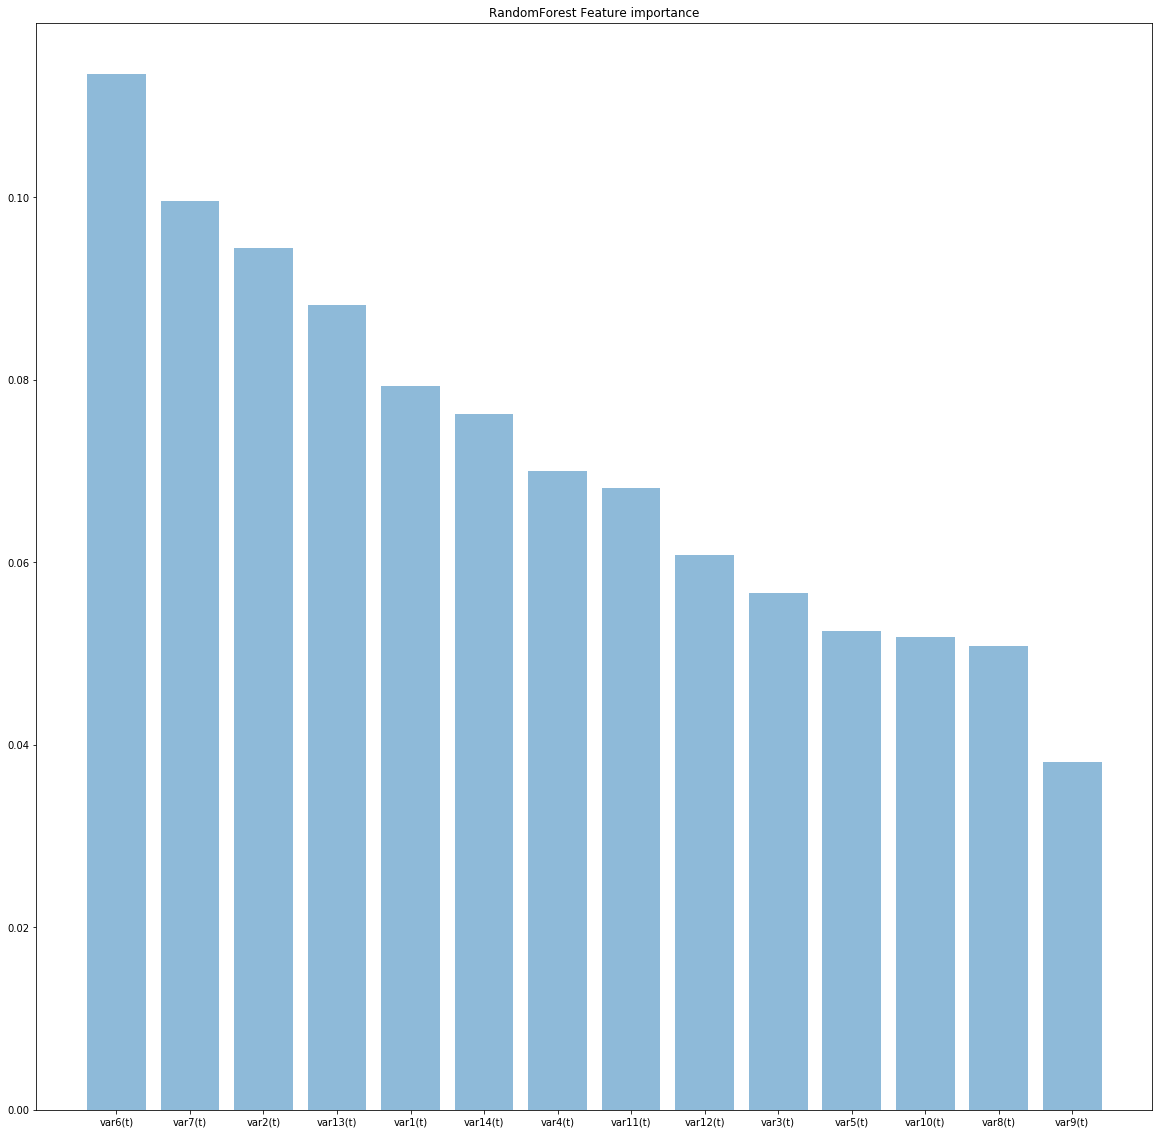

In [33]:
#
# Feature importance ranked using RandomForest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
#
rf.fit(df_pruned_shifted_X, df_pruned_shifted_Y)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = df_pruned_shifted_X_headers,
                                    columns=['importance']).sort_values('importance', ascending=False)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
print('Random Forest Classification For Feature Selection: ')
print(feature_importances)
#
# Plot the feature importance of the forest
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
plt.title("RandomForest Feature importance")
objects = list(feature_importances.axes[0])
y_pos = np.arange(len(objects))
feature_importance = np.array(feature_importances)
plt.bar(y_pos, feature_importance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

### Gradient Boosting Feature Importance Ranking

          importance
feature             
var2(t)     0.136585
var6(t)     0.134323
var13(t)    0.116963
var7(t)     0.099543
var14(t)    0.081333
var4(t)     0.079329
var1(t)     0.059840
var5(t)     0.059171
var12(t)    0.056994
var10(t)    0.050292
var11(t)    0.046642
var8(t)     0.038432
var3(t)     0.034189
var9(t)     0.006365


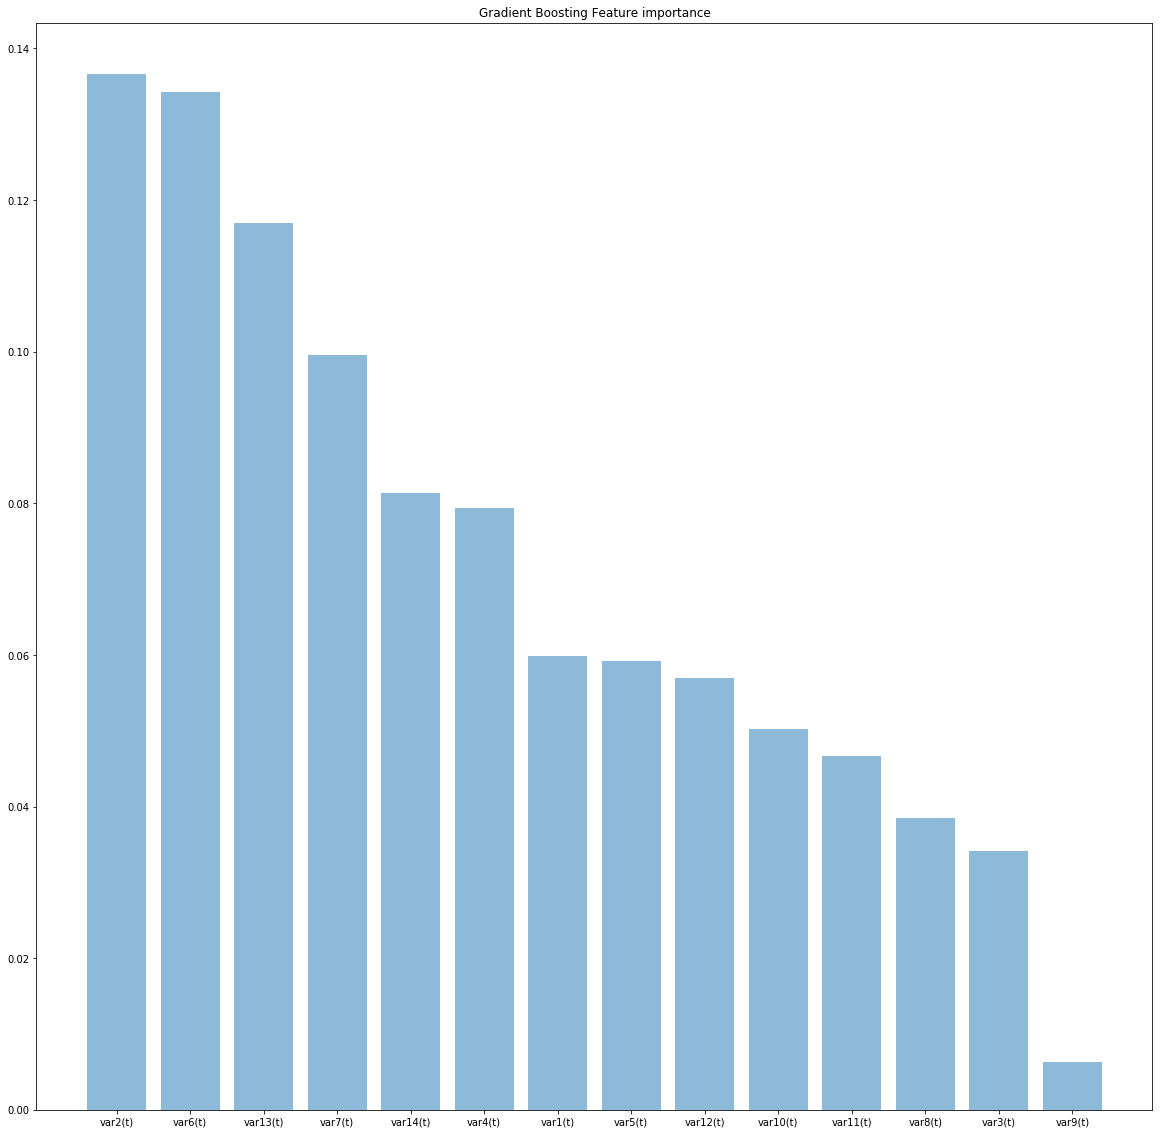

In [34]:
#
# Feature importance ranked using Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(df_pruned_shifted_X, df_pruned_shifted_Y)
feature_importances = pd.DataFrame({'feature': df_pruned_shifted_X_headers, 'importance': np.round(gbc.feature_importances_, 6)})
feature_importances = feature_importances.sort_values('importance', ascending=False).set_index('feature')
#
print(feature_importances)
#
# Plot the feature importance of the forest
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
plt.title("Gradient Boosting Feature importance")
objects = list(feature_importances.axes[0])
y_pos = np.arange(len(objects))
feature_importance = np.array(feature_importances)
plt.bar(y_pos, feature_importance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

### Evaluation Metrics

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
#
class Scoring_Functions():
    #
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
    #
    def accuracy(self):
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
        return str(accuracy_score(self.y_true, self.y_pred) * 100) + "%"
    #
    def precision(self):
        # http: // scikit - learn.org / stable / modules / generated / sklearn.metrics.precision_score.html  # sklearn.metrics.precision_score
        return str(precision_score(self.y_true, self.y_pred, average='weighted')* 100) + '%'
    #
    def recall(self):
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
        return str(recall_score(self.y_true, self.y_pred, average='weighted') * 100) + '%'
    #
    def f_measure(self):
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
        return str(f1_score(self.y_true, self.y_pred, average='weighted') * 100) + '%'
    #
    def scoring_results(self):
        return "Accuracy: " + str(self.accuracy()) + "\nPrecision: " + str(self.precision()) + "\nRecall: " + str(self.recall()) + "\nFMeasure: " + str(self.f_measure())

### Random Forest Feature Importance Wrapper Ranking (Backward Elimination)

In [36]:
# Wrapper Method - Random Forest Backward Feature Elimination
from numpy import sort
from sklearn.feature_selection import SelectFromModel
#
# Splitting into Training/Validating data subsets
test_size = (.2,.3,.4)# 80/20%, 70/30%, 60/40%
for t in test_size:
    X_train, X_test, y_train, y_test = train_test_split(df_pruned_shifted_X, df_pruned_shifted_Y, test_size=t, random_state=0)
    #
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    feature_importances = pd.DataFrame({'feature': df_pruned_shifted_X_headers, 'importance': np.round(rfc.feature_importances_, 6)})
    feature_importances = feature_importances.sort_values('importance', ascending=False).set_index('feature')
    #
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    #
    # make predictions for test data and evaluate
    pred_y = model.predict(X_test)
    #
    # Testing Classifier Accuracy
    sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
    print("RFC Accuracy with " + str(t) + " sub sampling: ")
    print(sf.scoring_results())
    print('-------------------------')
    #
    # fit model using each importance as a threshold
    thresholds = sort(model.feature_importances_)
    for thresh in thresholds:
        # selecting features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_train_x = selection.transform(X_train)
        #
        # training model
        selection_model = RandomForestClassifier()
        selection_model.fit(select_train_x, y_train)
        #
        # evaluating model
        select_test_x = selection.transform(X_test)
        pred_y = selection_model.predict(select_test_x)
        sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
        print('Threshold: ' + str(thresh))
        print('Feature Count: ' + str(select_train_x.shape[1]))
        print(sf.scoring_results())
        print('-------------------------')
    print('#############################\n#############################\n#############################')

RFC Accuracy with 0.2 sub sampling: 
Accuracy: 91.75%
Precision: 91.8077123856%
Recall: 91.75%
FMeasure: 91.7643438201%
-------------------------
Threshold: 0.0351392929056
Feature Count: 14
Accuracy: 90.35%
Precision: 90.4426367197%
Recall: 90.35%
FMeasure: 90.371474321%
-------------------------
Threshold: 0.0450467896742
Feature Count: 13
Accuracy: 91.1%
Precision: 91.1563809524%
Recall: 91.1%
FMeasure: 91.1149114734%
-------------------------
Threshold: 0.0493446091744
Feature Count: 12
Accuracy: 91.75%
Precision: 91.8145868101%
Recall: 91.75%
FMeasure: 91.7653735752%
-------------------------
Threshold: 0.0521808709288
Feature Count: 11
Accuracy: 91.3%
Precision: 91.4485970663%
Recall: 91.3%
FMeasure: 91.3256193325%
-------------------------
Threshold: 0.0610904446962
Feature Count: 10
Accuracy: 91.45%
Precision: 91.5552008393%
Recall: 91.45%
FMeasure: 91.4709994636%
-------------------------
Threshold: 0.0617962606451
Feature Count: 9
Accuracy: 89.15%
Precision: 89.2158982515%
Re

### Gradient Boosting Feature Importance Wrapper Ranking (Backward Elimination)

In [37]:
#
# Splitting into Training/Validating data subsets
test_size = (.2,.3,.4)# 80/20%, 70/30%, 60/40%
for t in test_size:
    X_train, X_test, y_train, y_test = train_test_split(df_pruned_shifted_X, df_pruned_shifted_Y, test_size=t, random_state=0)
    #
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    #
    # make predictions for test data and evaluate
    pred_y = model.predict(X_test)
    #
    # Testing Classifier Accuracy
    sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
    print("GBC Accuracy with " + str(t) + " sub sampling: ")
    print(sf.scoring_results())
    print('-------------------------')
    #
    # fit model using each importance as a threshold
    thresholds = sort(model.feature_importances_)
    for thresh in thresholds:
        # selecting features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_train_x = selection.transform(X_train)
        #
        # training model
        selection_model = GradientBoostingClassifier()
        selection_model.fit(select_train_x, y_train)
        #
        # evaluating model
        select_test_x = selection.transform(X_test)
        pred_y = selection_model.predict(select_test_x)
        sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
        print('Threshold: ' + str(thresh))
        print('Feature Count: ' + str(select_train_x.shape[1]))
        print(sf.scoring_results())
        print('-------------------------')
    print('#############################\n#############################\n#############################')

GBC Accuracy with 0.2 sub sampling: 
Accuracy: 84.35%
Precision: 84.3432493471%
Recall: 84.35%
FMeasure: 84.2545398917%
-------------------------
Threshold: 0.00657300364633
Feature Count: 14
Accuracy: 84.35%
Precision: 84.3432493471%
Recall: 84.35%
FMeasure: 84.2545398917%
-------------------------
Threshold: 0.037160269949
Feature Count: 13
Accuracy: 84.65%
Precision: 84.6476226258%
Recall: 84.65%
FMeasure: 84.556369798%
-------------------------
Threshold: 0.0434503423893
Feature Count: 12
Accuracy: 82.95%
Precision: 82.9161465634%
Recall: 82.95%
FMeasure: 82.8535477985%
-------------------------
Threshold: 0.04510226396
Feature Count: 11
Accuracy: 83.4%
Precision: 83.3551942618%
Recall: 83.4%
FMeasure: 83.3323284035%
-------------------------
Threshold: 0.0478651670937
Feature Count: 10
Accuracy: 82.7%
Precision: 82.6473305962%
Recall: 82.7%
FMeasure: 82.6398068227%
-------------------------
Threshold: 0.0530466030665
Feature Count: 9
Accuracy: 81.85%
Precision: 81.7904067546%
Reca

# Implementation

### Feature Dropping

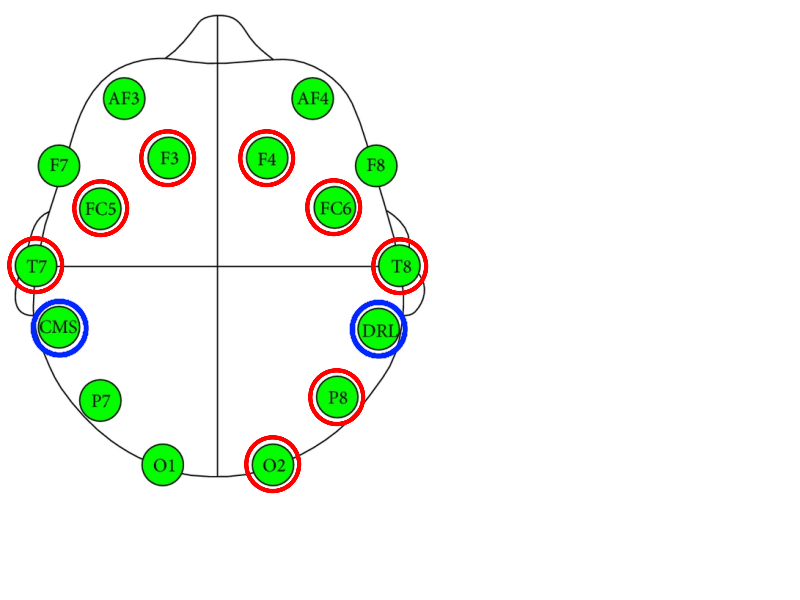

In [38]:
#
# Drop unwanted variables which decrease accuracy of overall prediction (as generated from RFC/GBC)
df_pruned_shifted_X_temp = df_pruned_shifted_X_pd
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var9(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var8(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var10(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var5(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var3(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var12(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var11(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var4(t)', 1)
#
# Visual representation of feature selection:
# Circles in Red are dropped features, 
# Circles in Blue are unprovided features (didn't feature in original dataset), 
# Unmarked features are considered for future tests
Image(filename="Images/EEG Emotiv Marked.png")

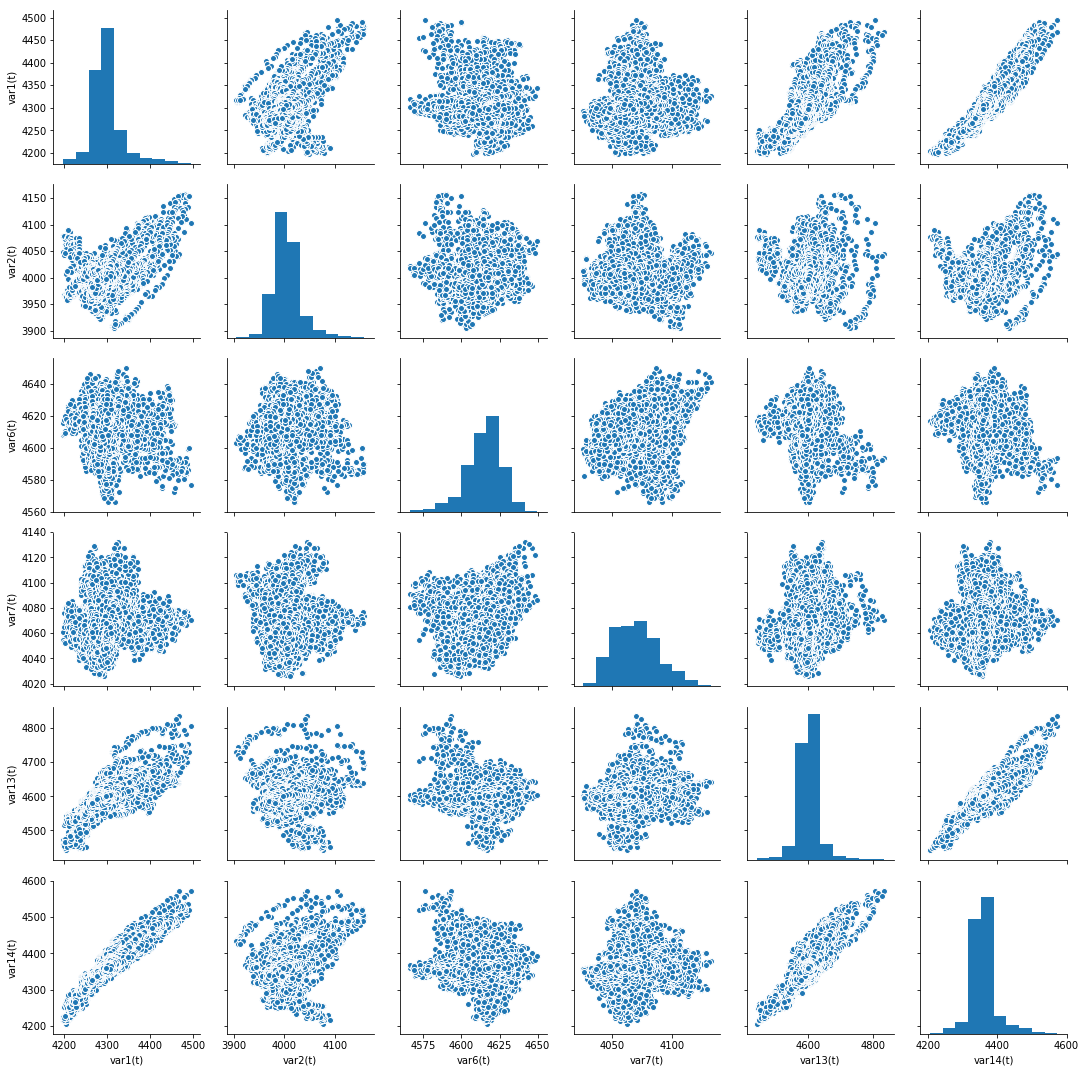

In [39]:
sns.pairplot(df_pruned_shifted_X_temp, kind="scatter")
plt.show()

### Logistic Regression (Using Grid Search)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#
# Splitting into Training/Validating data subsets
test_size = (.2,.3,.4)# 80/20%, 70/30%, 60/40%
C = (1,2,5,7,10,13)
solver = ('liblinear', 'sag', 'saga', 'newton-cg')
index_counter = 0
#
# grid search to find optimum hyper parameters, test split, feature selection
for ts in test_size:
    for c in C:
        for s in solver:
            #
            X_train, X_test, y_train, y_test = train_test_split(df_pruned_shifted_X_temp, df_pruned_shifted_Y, test_size=ts, random_state=0)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
#             X_train = normalize(X_train, norm='l2')
#             X_test = normalize(X_test, norm='l2')
            #
            clf = LogisticRegression(C=c,solver=s)
            clf.fit(X_train, y_train)
            #
            # make predictions for test data and evaluate
            pred_y = clf.predict(X_test)
            #
            # Testing Classifier Accuracy
            sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
            print("{{" + str(index_counter) + "}} Logistic Regression Accuracy with params: TestSize(" + str(ts) + "), C(" + str(c) + "), solver(" + str(s) + ")")
            print(sf.scoring_results())
            print('-------------------------')
            index_counter += 1

{{0}} Logistic Regression Accuracy with params: TestSize(0.2), C(1), solver(liblinear)
Accuracy: 61.0%
Precision: 61.110050578%
Recall: 61.0%
FMeasure: 61.050122399%
-------------------------
{{1}} Logistic Regression Accuracy with params: TestSize(0.2), C(1), solver(sag)
Accuracy: 60.95%
Precision: 61.0538883506%
Recall: 60.95%
FMeasure: 60.9975745969%
-------------------------
{{2}} Logistic Regression Accuracy with params: TestSize(0.2), C(1), solver(saga)
Accuracy: 60.95%
Precision: 61.0538883506%
Recall: 60.95%
FMeasure: 60.9975745969%
-------------------------
{{3}} Logistic Regression Accuracy with params: TestSize(0.2), C(1), solver(newton-cg)
Accuracy: 60.95%
Precision: 61.0538883506%
Recall: 60.95%
FMeasure: 60.9975745969%
-------------------------
{{4}} Logistic Regression Accuracy with params: TestSize(0.2), C(2), solver(liblinear)
Accuracy: 60.9%
Precision: 60.9239822263%
Recall: 60.9%
FMeasure: 60.9117492904%
-------------------------
{{5}} Logistic Regression Accuracy wi

Accuracy: 61.6666666667%
Precision: 61.39688754%
Recall: 61.6666666667%
FMeasure: 58.9608865313%
-------------------------
{{43}} Logistic Regression Accuracy with params: TestSize(0.3), C(10), solver(newton-cg)
Accuracy: 61.6666666667%
Precision: 61.39688754%
Recall: 61.6666666667%
FMeasure: 58.9608865313%
-------------------------
{{44}} Logistic Regression Accuracy with params: TestSize(0.3), C(13), solver(liblinear)
Accuracy: 61.6666666667%
Precision: 61.4037542197%
Recall: 61.6666666667%
FMeasure: 58.9447027892%
-------------------------
{{45}} Logistic Regression Accuracy with params: TestSize(0.3), C(13), solver(sag)
Accuracy: 61.6666666667%
Precision: 61.4037542197%
Recall: 61.6666666667%
FMeasure: 58.9447027892%
-------------------------
{{46}} Logistic Regression Accuracy with params: TestSize(0.3), C(13), solver(saga)
Accuracy: 61.6666666667%
Precision: 61.4037542197%
Recall: 61.6666666667%
FMeasure: 58.9447027892%
-------------------------
{{47}} Logistic Regression Accurac

### Linear Discriminant Analysis Classification

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#
# Splitting into Training/Validating data subsets
test_size = (.2,.3,.4)# 80/20%, 70/30%, 60/40%
index_counter = 0
#
# grid search to find optimum test split, feature selection
for ts in test_size:
    X_train, X_test, y_train, y_test = train_test_split(df_pruned_shifted_X_temp, df_pruned_shifted_Y, test_size=ts, random_state=0)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
#     X_train = normalize(X_train, norm='l2')
#     X_test = normalize(X_test, norm='l2')
    #
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train,y_train)
    #
    # make predictions for test data and evaluate
    pred_y = clf.predict(X_test)
    #
    # Testing Classifier Accuracy
    sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
    print("{{" + str(index_counter) + "}} Linear Discriminant Analysis Accuracy with params: TestSize(" + str(ts) + ")")
    print(sf.scoring_results())
    print('-------------------------')
    index_counter += 1

{{0}} Linear Discriminant Analysis Accuracy with params: TestSize(0.2)
Accuracy: 61.8%
Precision: 61.342203154%
Recall: 61.8%
FMeasure: 61.4340429957%
-------------------------
{{1}} Linear Discriminant Analysis Accuracy with params: TestSize(0.3)
Accuracy: 61.4666666667%
Precision: 61.3624116208%
Recall: 61.4666666667%
FMeasure: 58.2513949167%
-------------------------
{{2}} Linear Discriminant Analysis Accuracy with params: TestSize(0.4)
Accuracy: 62.325%
Precision: 62.0242586461%
Recall: 62.325%
FMeasure: 59.7138260726%
-------------------------


### Random Forest Classification (Using Grid Search)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
#
# Splitting into Training/Validating data subsets
test_size = (.2,.3,.4)# 80/20%, 70/30%, 60/40%
n_estimators = (10, 100, 1000)
max_features = (6, 'sqrt', 'log2')
criterion = ('gini','entropy')
n_jobs = 6
index_counter = 0
#
# grid search to find optimum hyper parameters, test split, feature selection
for ts in test_size:
    for n in n_estimators:
        for m in max_features:
            for c in criterion:
                #
                X_train, X_test, y_train, y_test = train_test_split(df_pruned_shifted_X_temp, df_pruned_shifted_Y, test_size=ts, random_state=0)
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)
#                 X_train = normalize(X_train, norm='l2')
#                 X_test = normalize(X_test, norm='l2')
                #
                clf = RandomForestClassifier(n_estimators=n, max_features=m, n_jobs=n_jobs, criterion=c)
                clf.fit(X_train, y_train)
                #
                # make predictions for test data and evaluate
                pred_y = clf.predict(X_test)
                #
                # Testing Classifier Accuracy
                sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
                print("{{" + str(index_counter) + "}} Random Forest Accuracy with params: TestSize(" + str(ts) + "), n_estimators(" + str(n) + "), max_features(" + str(m) + "), criterion(" + str(c) + ")")
                print(sf.scoring_results())
                print('-------------------------')
                index_counter += 1

{{0}} Random Forest Accuracy with params: TestSize(0.2), n_estimators(10), max_features(6), criterion(gini)
Accuracy: 71.05%
Precision: 72.2681413141%
Recall: 71.05%
FMeasure: 71.210732365%
-------------------------
{{1}} Random Forest Accuracy with params: TestSize(0.2), n_estimators(10), max_features(6), criterion(entropy)
Accuracy: 71.35%
Precision: 72.9219711538%
Recall: 71.35%
FMeasure: 71.4979942424%
-------------------------
{{2}} Random Forest Accuracy with params: TestSize(0.2), n_estimators(10), max_features(sqrt), criterion(gini)
Accuracy: 73.25%
Precision: 74.4945482149%
Recall: 73.25%
FMeasure: 73.3982015864%
-------------------------
{{3}} Random Forest Accuracy with params: TestSize(0.2), n_estimators(10), max_features(sqrt), criterion(entropy)
Accuracy: 72.0%
Precision: 73.1862821278%
Recall: 72.0%
FMeasure: 72.155849638%
-------------------------
{{4}} Random Forest Accuracy with params: TestSize(0.2), n_estimators(10), max_features(log2), criterion(gini)
Accuracy: 72.

{{37}} Random Forest Accuracy with params: TestSize(0.4), n_estimators(10), max_features(6), criterion(entropy)
Accuracy: 81.825%
Precision: 81.9914022986%
Recall: 81.825%
FMeasure: 81.8711166683%
-------------------------
{{38}} Random Forest Accuracy with params: TestSize(0.4), n_estimators(10), max_features(sqrt), criterion(gini)
Accuracy: 81.1%
Precision: 81.1544591703%
Recall: 81.1%
FMeasure: 81.121328047%
-------------------------
{{39}} Random Forest Accuracy with params: TestSize(0.4), n_estimators(10), max_features(sqrt), criterion(entropy)
Accuracy: 80.825%
Precision: 80.8503134634%
Recall: 80.825%
FMeasure: 80.8361843636%
-------------------------
{{40}} Random Forest Accuracy with params: TestSize(0.4), n_estimators(10), max_features(log2), criterion(gini)
Accuracy: 81.475%
Precision: 81.534269971%
Recall: 81.475%
FMeasure: 81.4976141846%
-------------------------
{{41}} Random Forest Accuracy with params: TestSize(0.4), n_estimators(10), max_features(log2), criterion(entro

### SVM (Using Grid Search)

In [43]:
from sklearn import svm
#
# Splitting into Training/Validating data subsets
test_size = (.2,.3,.4)# 80/20%, 70/30%, 60/40%
kernel = ('rbf','linear','sigmoid')
C = (2,4,5,6,8)
gamma = (7,9,10,11,13)
degree = 3
index_counter = 0
#
# grid search to find optimum hyper parameters, test split, feature selection
for ts in test_size:
    for k in kernel:
        for c in C:
            for g in gamma:
                #
                X_train, X_test, y_train, y_test = train_test_split(df_pruned_shifted_X_temp, df_pruned_shifted_Y, test_size=ts, random_state=0)
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.fit_transform(X_test)
                #
                clf = svm.SVC(kernel=k, C=c, gamma=g, degree=degree)
                clf.fit(X_train, y_train)
                #
                # make predictions for validation data and evaluate
                pred_y = clf.predict(X_test)
                #
                # Testing Classifier Accuracy
                sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
                print("{{" + str(index_counter) + "}} SVM Accuracy with params: test_size(" + str(ts) + "), Kernel(" + str(k) + "), C(" + str(c) + "), Gamma(" + str(g) + ")")
                print(sf.scoring_results())
                print('-------------------------')
                index_counter += 1

{{0}} SVM Accuracy with params: test_size(0.2), Kernel(rbf), C(2), Gamma(7)
Accuracy: 77.5%
Precision: 77.6171451217%
Recall: 77.5%
FMeasure: 77.543314405%
-------------------------
{{1}} SVM Accuracy with params: test_size(0.2), Kernel(rbf), C(2), Gamma(9)
Accuracy: 78.15%
Precision: 78.1746662707%
Recall: 78.15%
FMeasure: 78.1613677711%
-------------------------
{{2}} SVM Accuracy with params: test_size(0.2), Kernel(rbf), C(2), Gamma(10)
Accuracy: 78.05%
Precision: 78.022141644%
Recall: 78.05%
FMeasure: 78.0344721668%
-------------------------
{{3}} SVM Accuracy with params: test_size(0.2), Kernel(rbf), C(2), Gamma(11)
Accuracy: 78.45%
Precision: 78.4023220874%
Recall: 78.45%
FMeasure: 78.4204160712%
-------------------------
{{4}} SVM Accuracy with params: test_size(0.2), Kernel(rbf), C(2), Gamma(13)
Accuracy: 79.3%
Precision: 79.2526554066%
Recall: 79.3%
FMeasure: 79.2698109608%
-------------------------
{{5}} SVM Accuracy with params: test_size(0.2), Kernel(rbf), C(4), Gamma(7)
Ac

{{45}} SVM Accuracy with params: test_size(0.2), Kernel(linear), C(8), Gamma(7)
Accuracy: 62.75%
Precision: 62.1153159939%
Recall: 62.75%
FMeasure: 61.9855124842%
-------------------------
{{46}} SVM Accuracy with params: test_size(0.2), Kernel(linear), C(8), Gamma(9)
Accuracy: 62.75%
Precision: 62.1153159939%
Recall: 62.75%
FMeasure: 61.9855124842%
-------------------------
{{47}} SVM Accuracy with params: test_size(0.2), Kernel(linear), C(8), Gamma(10)
Accuracy: 62.75%
Precision: 62.1153159939%
Recall: 62.75%
FMeasure: 61.9855124842%
-------------------------
{{48}} SVM Accuracy with params: test_size(0.2), Kernel(linear), C(8), Gamma(11)
Accuracy: 62.75%
Precision: 62.1153159939%
Recall: 62.75%
FMeasure: 61.9855124842%
-------------------------
{{49}} SVM Accuracy with params: test_size(0.2), Kernel(linear), C(8), Gamma(13)
Accuracy: 62.75%
Precision: 62.1153159939%
Recall: 62.75%
FMeasure: 61.9855124842%
-------------------------
{{50}} SVM Accuracy with params: test_size(0.2), Ker

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{{51}} SVM Accuracy with params: test_size(0.2), Kernel(sigmoid), C(2), Gamma(9)
Accuracy: 57.45%
Precision: 33.005025%
Recall: 57.45%
FMeasure: 41.924452207%
-------------------------
{{52}} SVM Accuracy with params: test_size(0.2), Kernel(sigmoid), C(2), Gamma(10)
Accuracy: 57.45%
Precision: 33.005025%
Recall: 57.45%
FMeasure: 41.924452207%
-------------------------
{{53}} SVM Accuracy with params: test_size(0.2), Kernel(sigmoid), C(2), Gamma(11)
Accuracy: 57.45%
Precision: 33.005025%
Recall: 57.45%
FMeasure: 41.924452207%
-------------------------
{{54}} SVM Accuracy with params: test_size(0.2), Kernel(sigmoid), C(2), Gamma(13)
Accuracy: 57.45%
Precision: 33.005025%
Recall: 57.45%
FMeasure: 41.924452207%
-------------------------
{{55}} SVM Accuracy with params: test_size(0.2), Kernel(sigmoid), C(4), Gamma(7)
Accuracy: 57.45%
Precision: 33.005025%
Recall: 57.45%
FMeasure: 41.924452207%
-------------------------
{{56}} SVM Accuracy with params: test_size(0.2), Kernel(sigmoid), C(4), 

{{95}} SVM Accuracy with params: test_size(0.3), Kernel(rbf), C(8), Gamma(7)
Accuracy: 80.5666666667%
Precision: 80.5735708204%
Recall: 80.5666666667%
FMeasure: 80.4164216593%
-------------------------
{{96}} SVM Accuracy with params: test_size(0.3), Kernel(rbf), C(8), Gamma(9)
Accuracy: 81.6666666667%
Precision: 81.7359344998%
Recall: 81.6666666667%
FMeasure: 81.5006889899%
-------------------------
{{97}} SVM Accuracy with params: test_size(0.3), Kernel(rbf), C(8), Gamma(10)
Accuracy: 82.1333333333%
Precision: 82.2191757294%
Recall: 82.1333333333%
FMeasure: 81.9687165537%
-------------------------
{{98}} SVM Accuracy with params: test_size(0.3), Kernel(rbf), C(8), Gamma(11)
Accuracy: 82.4333333333%
Precision: 82.5538829304%
Recall: 82.4333333333%
FMeasure: 82.2585897833%
-------------------------
{{99}} SVM Accuracy with params: test_size(0.3), Kernel(rbf), C(8), Gamma(13)
Accuracy: 83.3666666667%
Precision: 83.5553261652%
Recall: 83.3666666667%
FMeasure: 83.1844017678%
-------------

{{136}} SVM Accuracy with params: test_size(0.3), Kernel(sigmoid), C(5), Gamma(9)
Accuracy: 56.5666666667%
Precision: 31.9978777778%
Recall: 56.5666666667%
FMeasure: 40.874444681%
-------------------------
{{137}} SVM Accuracy with params: test_size(0.3), Kernel(sigmoid), C(5), Gamma(10)
Accuracy: 56.5666666667%
Precision: 31.9978777778%
Recall: 56.5666666667%
FMeasure: 40.874444681%
-------------------------
{{138}} SVM Accuracy with params: test_size(0.3), Kernel(sigmoid), C(5), Gamma(11)
Accuracy: 56.5666666667%
Precision: 31.9978777778%
Recall: 56.5666666667%
FMeasure: 40.874444681%
-------------------------
{{139}} SVM Accuracy with params: test_size(0.3), Kernel(sigmoid), C(5), Gamma(13)
Accuracy: 56.5666666667%
Precision: 31.9978777778%
Recall: 56.5666666667%
FMeasure: 40.874444681%
-------------------------
{{140}} SVM Accuracy with params: test_size(0.3), Kernel(sigmoid), C(6), Gamma(7)
Accuracy: 56.5666666667%
Precision: 31.9978777778%
Recall: 56.5666666667%
FMeasure: 40.8744

{{179}} SVM Accuracy with params: test_size(0.4), Kernel(linear), C(2), Gamma(13)
Accuracy: 61.925%
Precision: 61.6276964379%
Recall: 61.925%
FMeasure: 59.0146793891%
-------------------------
{{180}} SVM Accuracy with params: test_size(0.4), Kernel(linear), C(4), Gamma(7)
Accuracy: 61.8%
Precision: 61.4782040352%
Recall: 61.8%
FMeasure: 58.8481818182%
-------------------------
{{181}} SVM Accuracy with params: test_size(0.4), Kernel(linear), C(4), Gamma(9)
Accuracy: 61.8%
Precision: 61.4782040352%
Recall: 61.8%
FMeasure: 58.8481818182%
-------------------------
{{182}} SVM Accuracy with params: test_size(0.4), Kernel(linear), C(4), Gamma(10)
Accuracy: 61.8%
Precision: 61.4782040352%
Recall: 61.8%
FMeasure: 58.8481818182%
-------------------------
{{183}} SVM Accuracy with params: test_size(0.4), Kernel(linear), C(4), Gamma(11)
Accuracy: 61.8%
Precision: 61.4782040352%
Recall: 61.8%
FMeasure: 58.8481818182%
-------------------------
{{184}} SVM Accuracy with params: test_size(0.4), Ker

{{223}} SVM Accuracy with params: test_size(0.4), Kernel(sigmoid), C(8), Gamma(11)
Accuracy: 56.95%
Precision: 32.433025%
Recall: 56.95%
FMeasure: 41.3291175534%
-------------------------
{{224}} SVM Accuracy with params: test_size(0.4), Kernel(sigmoid), C(8), Gamma(13)
Accuracy: 56.95%
Precision: 32.433025%
Recall: 56.95%
FMeasure: 41.3291175534%
-------------------------


# Test File Evaluation

### Test File Evaluation (Running trained model on completely unseen data)

In [44]:
# Training Model using training data, optimum hyper parameters and selected features
#
# Drop unwanted variables which decrease accuracy of overall prediction (as generated from RFC/GBC)
df_pruned_shifted_X_temp = df_pruned_shifted_X_pd
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var9(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var8(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var10(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var5(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var3(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var12(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var11(t)', 1)
df_pruned_shifted_X_temp = df_pruned_shifted_X_temp.drop('var4(t)', 1)
#
X_train, X_test, y_train, y_test = train_test_split(df_pruned_shifted_X_temp, df_pruned_shifted_Y, test_size=.3, random_state=0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# X_train = normalize(X_train, norm='l2')
# X_test = normalize(X_test, norm='l2')
# X_train = normalize(X_train, norm='l1')
# X_test = normalize(X_test, norm='l1')
#
kernel = 'rbf'
C = 5
g = 10
degree = 3
cache_size = 7000
clf = svm.SVC(kernel=kernel, C=C, gamma=g, degree=degree, cache_size=cache_size)
clf.fit(X_train, y_train)
#
# n=10000
# m='sqrt'
# n_jobs=6
# c='entropy'
# clf = RandomForestClassifier(n_estimators=n, max_features=m, n_jobs=n_jobs, criterion=c)
# clf.fit(X_train, y_train)
#
# make predictions for test data and evaluate
pred_y = clf.predict(X_test)
#
# Testing Classifier Accuracy
sf = Scoring_Functions(y_pred=pred_y, y_true=y_test)
print("{{" + str(index_counter) + "}} SVM Accuracy with params: TestSize(" + str(.4) + "), kernel(" + str(kernel) + "), C(" + str(C) + "), gamma(" + str(g) + "), degree(" + str(degree) + ")")
print(sf.scoring_results())
print('-------------------------')

{{225}} SVM Accuracy with params: TestSize(0.4), kernel(rbf), C(5), gamma(10), degree(3)
Accuracy: 81.7%
Precision: 81.7838094487%
Recall: 81.7%
FMeasure: 81.5269558973%
-------------------------


In [45]:
# Test File Evaluation
df_test = pd.read_csv(path_test)
df_test_values = df_test.values
df_test_values_count = len(df_test)
df_test_headers = df_test.columns
df_test_header_count = len(df_test_headers)
print('DF size before outlier removal: ' + str(df_test_values_count))
#
outlier_indexes = get_outlier_indexes(df_test_values, df_test_header_count)
print('Extreme outliers\nTotal:   ', len(outlier_indexes), \
    '\nIndexes: ', outlier_indexes)
# [(print(DataFrame(df).iloc[[outlier]])) for outlier in outlier_indexes]
df_test_values_pruned = np.delete(df_test_values, outlier_indexes, 0)
df_test_values_pruned_count = len(df_test_values_pruned)
df_test_pruned = pd.DataFrame(data=df_test_values_pruned, columns=df_test_headers)
print('DF size after outlier removal: ' + str(df_test_values_pruned_count))
#
# N-Step Univariate Forecasting Shift
lag = 0
df_test_pruned_shifted = series_to_supervised(data=df_test_pruned, n_in=lag, n_out=1, dropnan=True)
#
# Removing any lag variables of var15(t-lag) (label)
if lag > 0:
    for i in range(1,lag+1):
        df_test_pruned_shifted = df_test_pruned_shifted.drop('var15(t-' + str(i) + ')', 1)
df_test_pruned_shifted_headers = df_test_pruned_shifted.columns
df_test_pruned_shifted_header_count = len(df_test_pruned_shifted_headers)
print(df_test_pruned_shifted_headers)
#
# Feature/Label Selection
df_test_pruned_shifted_Y = df_test_pruned_shifted['var15(t)']
df_test_pruned_shifted_X = df_test_pruned_shifted.drop('var15(t)', 1)
df_test_pruned_shifted_X = df_test_pruned_shifted_X.drop('var9(t)', 1)
df_test_pruned_shifted_X = df_test_pruned_shifted_X.drop('var8(t)', 1)
df_test_pruned_shifted_X = df_test_pruned_shifted_X.drop('var10(t)', 1)
df_test_pruned_shifted_X = df_test_pruned_shifted_X.drop('var5(t)', 1)
df_test_pruned_shifted_X = df_test_pruned_shifted_X.drop('var3(t)', 1)
df_test_pruned_shifted_X = df_test_pruned_shifted_X.drop('var12(t)', 1)
df_test_pruned_shifted_X = df_test_pruned_shifted_X.drop('var11(t)', 1)
df_test_pruned_shifted_X = df_test_pruned_shifted_X.drop('var4(t)', 1)
#
# Feature MinMax Scaling
df_test_pruned_shifted_X = scaler.fit_transform(df_test_pruned_shifted_X)
df_test_pruned_shifted_Y = np.array(df_test_pruned_shifted_Y)
# df_pruned_shifted_X = normalize(df_pruned_shifted_X, norm='l1')
# df_pruned_shifted_Y = np.array(df_pruned_shifted_Y)
# df_pruned_shifted_X = normalize(df_pruned_shifted_X, norm='l2')
# df_pruned_shifted_Y = np.array(df_pruned_shifted_Y)
#
# Run data on best established model
pred_y_test = clf.predict(df_test_pruned_shifted_X)
#
# Testing Classifier Accuracy
sf = Scoring_Functions(y_pred=pred_y_test, y_true=df_test_pruned_shifted_Y)
print("Test Metrics: ")
print(sf.scoring_results())
print('-------------------------')

DF size before outlier removal: 4980
Extreme outliers
Total:    3 
Indexes:  [386, 1509, 3179]
DF size after outlier removal: 4977
Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)',
       'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)',
       'var13(t)', 'var14(t)', 'var15(t)'],
      dtype='object')
Test Metrics: 
Accuracy: 78.7823990356%
Precision: 78.3008250578%
Recall: 78.7823990356%
FMeasure: 78.5198982477%
-------------------------


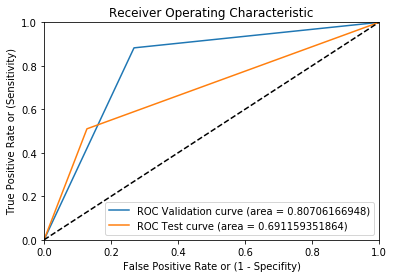

In [46]:
# Roc curve
from sklearn.metrics import roc_curve, auc
#
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, pred_y)
roc_auc = auc(fpr, tpr)
fpr2, tpr2, thresholds = roc_curve(df_test_pruned_shifted_Y, pred_y_test)
roc_auc2 = auc(fpr2, tpr2)
#
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC Validation curve (area = ' + str(roc_auc) +')')
plt.plot(fpr2, tpr2, label='ROC Test curve (area = ' + str(roc_auc2) +')')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()